In [1]:
# Importing all the libraries at once
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display_html
from itertools import chain,cycle

In [2]:
# This function is going to be used to display multiple frames side by side. This will especially help in analyzing pivot tables
# that are created later for data analysis
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [3]:
# this is set so that more rows and more columns can be seen for taking glimpse of data
pd.options.display.max_rows = 50
pd.options.display.max_columns = 150

# ===Data sourcing===

In [4]:
# Reading the csv file. low_memory is set to false to get rid of warning
loans_original = pd.read_csv("loan.csv", low_memory=False)

# ===Data cleaning===

In [5]:
# Original shape of loan data frame
loans_original.shape

(39717, 111)

## ---Fixing Columns---

### >>>Identifying Columns that have all NULL values

In [6]:
# fininding number of columns that have all the NULL values
len(loans_original.columns[loans_original.isnull().sum()==39717])

54

In [7]:
# finding number of columns that have at least one not NULL values
len(loans_original.columns[loans_original.isnull().sum() <39717])

57

In [8]:
# list of columns that have all the NULL values in them
loans_original.columns[loans_original.isnull().sum() == 39717]

Index(['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dl

In [9]:
# list of columns that have at least one not NULL values in them
loans_original.columns[loans_original.isnull().sum() <39717]

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_

### 1. Removing Columns that have all NULL values

In [10]:
loan_without_null_coulumns = loans_original.dropna(axis=1, how='all')

### 2. Removing Columns that have only one common value in all the rows

In [11]:
for i in loan_without_null_coulumns.columns:
    if(loan_without_null_coulumns[i].nunique() == 1):
        loan_without_null_coulumns = loan_without_null_coulumns.drop(i, axis=1)

### 3. Removing Columns pub_rec_bankruptcies and mths_since_last_delinq

pub_rec_bankruptcies has most of the alues as 0
mths_since_last_delinq has most of the values as NULL
and hence these two columns do not contribute any value in our analysis

In [12]:
loan_without_null_coulumns = loan_without_null_coulumns.drop(['pub_rec_bankruptcies', 'mths_since_last_delinq'], axis=1)

### Selecting right column from loan_amnt, funded_amnt and funded_amnt_inv

Out of loan_amnt and funded_amnt, funded_amnt is the one which is considered for actual loan. And when I calculate the EMI for this funnded_amount it comes same as installment column values. Also when I check total payment and total principal/interest values, they match in corresponding with funded_amnt. But all of these values do not go correctly with funded_amnt_inv column. So I am dropping loan_amnt and funded_amnt_inv columns and only keeping funded_amnt column

#### ***Keeping column funded_amnt for further analysis***

In [13]:
loan_without_null_coulumns[['term','loan_amnt','installment','funded_amnt','funded_amnt_inv','int_rate','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','issue_d','last_pymnt_d']]

term  loan_amnt  installment  funded_amnt  funded_amnt_inv  \
0       36 months       5000       162.87         5000           4975.0   
1       60 months       2500        59.83         2500           2500.0   
2       36 months       2400        84.33         2400           2400.0   
3       36 months      10000       339.31        10000          10000.0   
4       60 months       3000        67.79         3000           3000.0   
...           ...        ...          ...          ...              ...   
39712   36 months       2500        78.42         2500           1075.0   
39713   36 months       8500       275.38         8500            875.0   
39714   36 months       5000       156.84         5000           1325.0   
39715   36 months       5000       155.38         5000            650.0   
39716   36 months       7500       255.43         7500            800.0   

      int_rate  out_prncp  out_prncp_inv   total_pymnt  total_pymnt_inv  \
0       10.65%       0.00           0.00   5863.155187          5833.84   
1       15.27%       0.00           0.00   1008.710000          1008.71   
2       15.96%       0.00           0.00   3005.666844          3005.67   
3       13.49%       0.00           0.00  12231.890000         12231.89   
4       12.69%     524.06         524.06   3513.330000          3513.33   
...        ...        ...            ...           ...              ...   
39712    8.07%       0.00           0.00   2822.969293          1213.88   
39713   10.28%       0.00           0.00   9913.491822          1020.51   
39714    8.07%       0.00           0.00   5272.161128          1397.12   
39715    7.43%       0.00           0.00   5174.198551           672.66   
39716   13.75%       0.00           0.00   9195.263334           980.83   

       total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  \
0              5000.00         863.16                0.00        0.00   
1               456.46         435.17                0.00      117.08   
2              2400.00         605.67                0.00        0.00   
3             10000.00        2214.92               16.97        0.00   
4              2475.94        1037.39                0.00        0.00   
...                ...            ...                 ...         ...   
39712          2500.00         322.97                0.00        0.00   
39713          8500.00        1413.49                0.00        0.00   
39714          5000.00         272.16                0.00        0.00   
39715          5000.00         174.20                0.00        0.00   
39716          7500.00        1695.26                0.00        0.00   

       collection_recovery_fee issue_d last_pymnt_d  
0                         0.00  Dec-11       Jan-15  
1                         1.11  Dec-11       Apr-13  
2                         0.00  Dec-11       Jun-14  
3                         0.00  Dec-11       Jan-15  
4                         0.00  Dec-11       May-16  
...                        ...     ...          ...  
39712                     0.00  Jul-07       Jul-10  
39713                     0.00  Jul-07       Jul-10  
39714                     0.00  Jul-07       Apr-08  
39715                     0.00  Jul-07       Jan-08  
39716                     0.00  Jun-07       Jun-10  

[39717 rows x 17 columns]

In [14]:
loan_without_null_coulumns[loan_without_null_coulumns.loan_amnt != loan_without_null_coulumns.funded_amnt][['term','loan_amnt','installment','funded_amnt','funded_amnt_inv','int_rate','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','issue_d','last_pymnt_d']]

term  loan_amnt  installment  funded_amnt  funded_amnt_inv  \
61      60 months      17500       223.74         8950      8925.000000   
66      60 months      12500       223.11         8925      8925.000000   
70      60 months      20975       341.63        13575     13550.000000   
77      60 months       7250       197.51         7200      7175.000000   
80      60 months      35000       551.84        22075     22050.000000   
...           ...        ...          ...          ...              ...   
39533   36 months      10000       189.97         6000       700.000000   
39593   36 months      20000       162.01         4800      1949.999594   
39600   36 months       4000        32.25         1000       550.000000   
39601   36 months      12000       163.49         5000      1399.996684   
39611   36 months      25000       194.15         5650       725.000000   

      int_rate  out_prncp  out_prncp_inv   total_pymnt  total_pymnt_inv  \
61      17.27%        0.0            0.0  13227.100010         13190.15   
66      17.27%        0.0            0.0   5577.750000          5577.75   
70      17.58%        0.0            0.0  18112.460870         18079.10   
77      21.67%        0.0            0.0   8204.774089          8176.29   
80      17.27%        0.0            0.0  28887.100070         28854.39   
...        ...        ...            ...           ...              ...   
39533    8.70%        0.0            0.0   6778.258742           790.80   
39593   13.12%        0.0            0.0   1605.300000           651.62   
39600    9.96%        0.0            0.0    868.810000           477.36   
39601   10.91%        0.0            0.0   4820.710000          1347.19   
39611   14.38%        0.0            0.0   6989.312454           896.86   

       total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  \
61             8950.00        4277.10            0.000000        0.00   
66             2812.82        2742.43            0.000000       22.50   
70            13575.00        4537.46            0.000000        0.00   
77             7200.00        1004.77            0.000000        0.00   
80            22075.00        6812.10            0.000000        0.00   
...                ...            ...                 ...         ...   
39533          6000.00         778.26            0.000000        0.00   
39593          1028.79         427.59            0.000000      148.92   
39600           719.90         148.91            0.000000        0.00   
39601          3891.56         844.02           29.970725       55.16   
39611          5650.00        1339.31            0.000000        0.00   

       collection_recovery_fee issue_d last_pymnt_d  
61                      0.0000  Dec-11       Feb-16  
66                      0.0000  Dec-11       Feb-14  
70                      0.0000  Dec-11       Apr-14  
77                      0.0000  Dec-11       Sep-12  
80                      0.0000  Dec-11       Feb-14  
...                        ...     ...          ...  
39533                   0.0000  Dec-07       Apr-10  
39593                   5.7222  Oct-07       Aug-08  
39600                   0.0000  Oct-07       Jan-10  
39601                   0.7000  Oct-07       Mar-10  
39611                   0.0000  Oct-07       Oct-10  

[1849 rows x 17 columns]

### 4. Removing columns loan_amnt and funded_amnt_inv as they will not be used in our further analysis

In [15]:
loan_without_null_coulumns = loan_without_null_coulumns.drop(['loan_amnt', 'funded_amnt_inv'], axis=1)

### 5. Removing all the behavioral columns that are not required in our analysis as they play important role in prediction and we are not doing any predictions as a part of this case study

In [16]:
loan_without_null_and_behavioral_vals= loan_without_null_coulumns.drop(['delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 
                                                                    'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 
                                                                    'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
                                                                    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
                                                                    'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 
                                                                    'last_pymnt_amnt', 'last_credit_pull_d', 'next_pymnt_d',
                                                                    'mths_since_last_record'], axis=1)

### 6. Removing other miscellaneous columns that are not required for our current analysis

In [29]:
loan_with_required_cols = loan_without_null_and_behavioral_vals.drop(['id', 'member_id', 'emp_title', 
                                                                        'url', 'desc', 'title'], axis=1)

In [30]:
loan_with_required_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   funded_amnt          39717 non-null  int64  
 1   term                 39717 non-null  object 
 2   int_rate             39717 non-null  object 
 3   installment          39717 non-null  float64
 4   grade                39717 non-null  object 
 5   sub_grade            39717 non-null  object 
 6   emp_length           38642 non-null  object 
 7   home_ownership       39717 non-null  object 
 8   annual_inc           39717 non-null  float64
 9   verification_status  39717 non-null  object 
 10  issue_d              39717 non-null  object 
 11  loan_status          39717 non-null  object 
 12  purpose              39717 non-null  object 
 13  zip_code             39717 non-null  object 
 14  addr_state           39717 non-null  object 
 15  dti                  39717 non-null 

## ---Fixing Rows---

### 1. Rows with loan_status =  "Current"

This loan status indicate that the people are still paying the EMI of their respective loan hence these people do not contribute anything to our analysis where we are trying to identify defaulters and non-defaulters. Hence dropping the rows with loan_status="Current"

In [31]:
loan_with_required_cols = loan_with_required_cols[loan_with_required_cols.loan_status != "Current"]

### 2. Rows with emp_length = "NULL"

We are having around 1000 rows with emp_length value as NULL which are less (3%) in comparison with total available data hence safely removing such rows

In [32]:
loan_with_required_cols = loan_with_required_cols[~loan_with_required_cols.emp_length.isnull()]

### 3. Rows with home_ownership = "Other"/"None"

There are around 100 rows which have home_ownership mentioned as "OTHER" or "NONE". This does not give us any valuable information about their home ownership and also this data is small compared to other home_ownership types. Hence safely removing such rows

In [33]:
loan_with_required_cols = loan_with_required_cols[~((loan_with_required_cols.home_ownership == "NONE") | (loan_with_required_cols.home_ownership == "OTHER"))]

## ---Standardising Values--

### 1. Remove outliers

#### a. Annual Income

From below boxplot, it is seen that there are many outliers when it comes to annual income and we can consider annual income less than or equal to USD150k

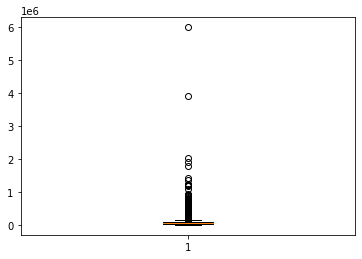

In [34]:
plt.boxplot(loan_with_required_cols.annual_inc)
plt.show()

#### Rows with annual_income >= 150000 will be removed

In [35]:
inc_150k_less = loan_with_required_cols[loan_with_required_cols.annual_inc <= 150000]

#### below boxplot now looks well in limits

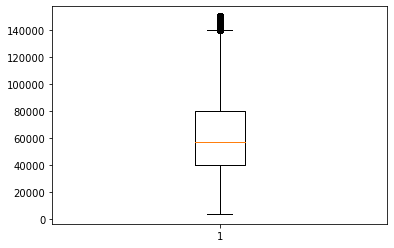

In [36]:
plt.boxplot(inc_150k_less.annual_inc)
plt.show()

#### b. Funded Amount

From below boxplot, it is seen that there are many outliers when it comes to funded amount and we can consider funded amount less than or equal to USD30k

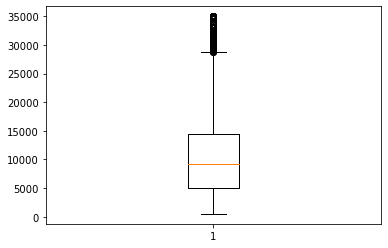

In [37]:
plt.boxplot(inc_150k_less.funded_amnt)
plt.show()

#### Rows with funded amount >= 30000 will be removed

In [38]:
inc_150k_fund_30k = inc_150k_less[inc_150k_less.funded_amnt <= 30000]

#### below boxplot now looks well in limits

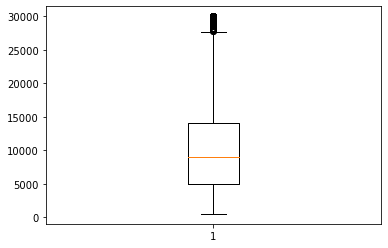

In [39]:
plt.boxplot(inc_150k_fund_30k.funded_amnt)
plt.show()

### 2. Standardising amounts to dollars instead of having cents in them

Converting monthly/annual amounts into whole dollar values instead of having cents in them

In [40]:
inc_150k_fund_30k.annual_inc = inc_150k_fund_30k.annual_inc.astype('int64')
inc_150k_fund_30k.installment = inc_150k_fund_30k.installment.astype('int64')

C:\Users\atalkatk\MyStuff\UpGrad\Anaconda\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## ---Invalid Values--

### Convert incorrect data types

In [41]:
#1. Converting int_rate from string object to float datatype
inc_150k_fund_30k.int_rate = inc_150k_fund_30k.int_rate.apply(lambda x: float(x.replace("%","")))

In [42]:
#2. Converting emp_length from string object to int datatype
# Function to modify not null values in emp_length in order to convert them into int
def mod_emp_len(val):
    val.emp_length = str(val.emp_length).replace("+","").replace(" years","").replace("< ","").replace(" year","")
    return int(val.emp_length)

inc_150k_fund_30k['emp_length'] = inc_150k_fund_30k.apply(lambda x: mod_emp_len(x) ,axis=1)

C:\Users\atalkatk\AppData\Local\Temp/ipykernel_19348/883552689.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inc_150k_fund_30k['emp_length'] = inc_150k_fund_30k.apply(lambda x: mod_emp_len(x) ,axis=1)


In [43]:
# 3. Converting issue_d and earliest_cr_line string objects to pandas datetime objects
inc_150k_fund_30k.issue_d = pd.to_datetime(inc_150k_fund_30k["issue_d"],format="%b-%y")
inc_150k_fund_30k.earliest_cr_line = pd.to_datetime(inc_150k_fund_30k["earliest_cr_line"],format="%b-%y")

### Data Frame to use for below analysis

In [44]:
loan_analyse = inc_150k_fund_30k

#Reset the index
loan_analyse.reset_index(inplace=True, drop=True)

## ---Filtering Data---

## Aggregate data

### 1. Using emp_length column to create groups of people based upon their experience level

Categorization is done as below:
    <br> &emsp;&emsp;&emsp; Freshers: 0 to 2 years
    <br> &emsp;&emsp;&emsp; Intermediate: 2 to 5 years
    <br> &emsp;&emsp;&emsp; Experienced: 5 to 9 years
    <br> &emsp;&emsp;&emsp; Seniors: 10 years and more

In [45]:
exp_levels = ["Fresher","Intermediate","Experience","Senior"]
cut_bins = [0, 2, 5, 9, 10]
loan_analyse["exp_level"] = pd.cut(loan_analyse['emp_length'], bins=cut_bins, labels=exp_levels, include_lowest=True)

C:\Users\atalkatk\AppData\Local\Temp/ipykernel_19348/3475395480.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_analyse["exp_level"] = pd.cut(loan_analyse['emp_length'], bins=cut_bins, labels=exp_levels, include_lowest=True)


### 2. Using funded_amnt column to create groups of people based upon the volume of funded amount

Categorization is done as below:
    <br> &emsp;&emsp;&emsp; Small Loan: Loan up to USD5k
    <br> &emsp;&emsp;&emsp; Medium Loan: Loan between USD5k and USD10k
    <br> &emsp;&emsp;&emsp; Big Loan: Loan between USD10k and USD20k
    <br> &emsp;&emsp;&emsp; Heavy Loan: Loan more than USD20k

In [46]:
loan_volume = ["Small Loan","Medium Loan","Big Loan", "Heavy Loan"]
cut_bins = [0, 5000, 10000, 20000, 30000]
loan_analyse["loan_volume"] = pd.cut(loan_analyse['funded_amnt'], bins=cut_bins, labels=loan_volume, include_lowest=True)

C:\Users\atalkatk\AppData\Local\Temp/ipykernel_19348/355215231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_analyse["loan_volume"] = pd.cut(loan_analyse['funded_amnt'], bins=cut_bins, labels=loan_volume, include_lowest=True)


### 3. Using annual_inc column to create groups of people based upon their annual income

Categorization is done as below:
    <br> &emsp;&emsp;&emsp; Poor: Annual income up to USD30k
    <br> &emsp;&emsp;&emsp; Lower Middle Clss: Annual income between USD30k and USD60k
    <br> &emsp;&emsp;&emsp; Middle Class: Annual income between USD60k and USD90k
    <br> &emsp;&emsp;&emsp; Upper Middle Class: Annual income between USD90k and USD120k
    <br> &emsp;&emsp;&emsp; Rich: Annual income more than USD120k

In [47]:
income_levels = ["Poor","Lower Middle","Middle", "Upper Middle", "Rich"]
cut_bins = [0, 30000, 60000, 90000, 120000, 150000]
loan_analyse["income_group"] = pd.cut(loan_analyse['annual_inc'], bins=cut_bins, labels=income_levels, include_lowest=True)

C:\Users\atalkatk\AppData\Local\Temp/ipykernel_19348/3982904355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_analyse["income_group"] = pd.cut(loan_analyse['annual_inc'], bins=cut_bins, labels=income_levels, include_lowest=True)


### 4. Using dti column to create groups of people based upon their debt profile

Categorization is done as below:
    <br> &emsp;&emsp;&emsp; Very Low Debt: dti up to 5
    <br> &emsp;&emsp;&emsp; Low Debt: dti between 5 and 10
    <br> &emsp;&emsp;&emsp; Moderate Debt: dti between 10 and 15
    <br> &emsp;&emsp;&emsp; High Debt: dti between 15 and 20
    <br> &emsp;&emsp;&emsp; Very High Debt: dti more than 20

In [48]:
debt_profile = ["Very Low Debt", "Low Debt", "Moderate Debt", "High Debt", "Very High Debt"]
cut_bins = [0.0, 5.0, 10.0, 15.0, 20.0, 30.0]
loan_analyse["debt_profile"] = pd.cut(loan_analyse['dti'], bins=cut_bins, labels=debt_profile, include_lowest=True)

C:\Users\atalkatk\AppData\Local\Temp/ipykernel_19348/2232740230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_analyse["debt_profile"] = pd.cut(loan_analyse['dti'], bins=cut_bins, labels=debt_profile, include_lowest=True)


### 5. Using int_rate column to create groups of people based upon their interest rate

Categorization is done as below:
    <br> &emsp;&emsp;&emsp; Very Low Debt: dti up to 5
    <br> &emsp;&emsp;&emsp; Low Debt: dti between 5 and 10
    <br> &emsp;&emsp;&emsp; Moderate Debt: dti between 10 and 15
    <br> &emsp;&emsp;&emsp; High Debt: dti between 15 and 20
    <br> &emsp;&emsp;&emsp; Very High Debt: dti more than 20

In [49]:
int_rate = ["Low Int Rate", "Average Int Rate", "High Int Rate", "Very High Rate"]
cut_bins = [5.0, 10.0, 15.0, 20.0, 25.0]
loan_analyse["int_rate_group"] = pd.cut(loan_analyse['int_rate'], bins=cut_bins, labels=int_rate, include_lowest=True)

C:\Users\atalkatk\AppData\Local\Temp/ipykernel_19348/3806405215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_analyse["int_rate_group"] = pd.cut(loan_analyse['int_rate'], bins=cut_bins, labels=int_rate, include_lowest=True)


### 6. Using installment column to create groups of people based upon monthly installment of loan

Categorization is done as below:
    <br> &emsp;&emsp;&emsp; Low EMI: Installment up to 100
    <br> &emsp;&emsp;&emsp; Moderate EMI: Installment between 100 and 300
    <br> &emsp;&emsp;&emsp; High EMI: Installment between 300 and 400
    <br> &emsp;&emsp;&emsp; Very High EMI: Installment more than 400

In [51]:
emi_type = ["Low EMI", "Moderate EMI", "High EMI", "Very High EMI"]
cut_bins = [0, 100, 300, 400, 1200]
loan_analyse["emi_type"] = pd.cut(loan_analyse['installment'], bins=cut_bins, labels=emi_type, include_lowest=True)

C:\Users\atalkatk\AppData\Local\Temp/ipykernel_19348/1982288414.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_analyse["emi_type"] = pd.cut(loan_analyse['installment'], bins=cut_bins, labels=emi_type, include_lowest=True)


### 7. Using dti column to create groups of people based upon their debt profile

Categorization is done as below:
    <br> &emsp;&emsp;&emsp; Midwest: 'ND','MN','SD','IA','NE','KS','MO','WI','MI','OH','IN','IL
    <br> &emsp;&emsp;&emsp; Northeast: 'PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'NH', 'VT', 'ME'
    <br> &emsp;&emsp;&emsp; West: 'WA','OR', 'MT','ID','WY','NV','UT','CO','CA','AZ','NM', 'AK', 'HI'
    <br> &emsp;&emsp;&emsp; South: 'TX','OK','AR','LA','MS','AL','TN','KY','GA','FL','SC','NC','VA','WV','DC','DE','MD'

In [52]:
state_region_codes = { 'Midwest': ['ND','MN','SD','IA','NE','KS','MO','WI','MI','OH','IN','IL'],
                       'Northeast': ['PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'NH', 'VT', 'ME'],
                       'West': ['WA','OR', 'MT','ID','WY','NV','UT','CO','CA','AZ','NM', 'AK', 'HI'],
                       'South': ['TX','OK','AR','LA','MS','AL','TN','KY','GA','FL','SC','NC','VA','WV','DC','DE','MD']
                     }

def find_state_region(val):
    if val in state_region_codes['Midwest']:
        return "Midwest"
    elif val in state_region_codes['Northeast']:
        return "Northeast"
    elif val in state_region_codes['West']:
        return "West"
    elif val in state_region_codes['South']:
        return "South"

loan_analyse['state_region'] = loan_analyse.addr_state
loan_analyse['state_region'] = loan_analyse.state_region.apply(lambda x: find_state_region(x))

C:\Users\atalkatk\AppData\Local\Temp/ipykernel_19348/3173006901.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_analyse['state_region'] = loan_analyse.addr_state
C:\Users\atalkatk\AppData\Local\Temp/ipykernel_19348/3173006901.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_analyse['state_region'] = loan_analyse.state_region.apply(lambda x: find_state_region(x))


# ===Data Analysis=== & ===Data Visualization===

[10:38 PM] Bind, Veena
## Understanding The ColumnsList of columns in the final dataframe:
<br> &emsp;&emsp;&emsp;
<ul>
<li>'funded_amnt',</li>
<li>'term', </li>
<li>'int_rate', </li>
<li>'installment',</li>
<li>'grade', </li>
<li>'sub_grade',</li>
<li>'emp_length',</li>
<li>'home_ownership', </li>
<li>'annual_inc', </li>
<li>'verification_status',</li>
<li>'issue_d', </li>
<li>'loan_status',</li>
<li>'purpose', </li>
<li>'zip_code', </li>
<li>'addr_state',</li>
<li>'dti', </li>
<li>'earliest_cr_line', </li>
<li>'exp_level', </li>
<li>'loan_volume',</li>
<li>'income_group',</li>
<li>'debt_profile', </li>
<li>'state_region', </li>
<li>'int_rate_group',</li>
<li>'emi_type'</li>

<b>quantitative variables: </b>
<br> &emsp;&emsp;&emsp; funded_amnt
<br> &emsp;&emsp;&emsp; int_rate
<br> &emsp;&emsp;&emsp; installment
<br> &emsp;&emsp;&emsp; emp_length
<br> &emsp;&emsp;&emsp; annual_inc
<br> &emsp;&emsp;&emsp; dti
  
<b>Ordered Categorical Variables: </b>
<br> &emsp;&emsp;&emsp; funded_amnt <==> loan_volume
<br> &emsp;&emsp;&emsp; term
<br> &emsp;&emsp;&emsp; int_rate <==> int_rate_group
<br> &emsp;&emsp;&emsp; installment <==> emi_type
<br> &emsp;&emsp;&emsp; grade
<br> &emsp;&emsp;&emsp; sub_grade
<br> &emsp;&emsp;&emsp; emp_length <==> exp_level
<br> &emsp;&emsp;&emsp; annual_inc <==> income_group
<br> &emsp;&emsp;&emsp; verification_status
<br> &emsp;&emsp;&emsp; issue_d
<br> &emsp;&emsp;&emsp; dti <==> debt_profile
    
<b>Unordered Categorical Variables:</b>
<br> &emsp;&emsp;&emsp; home_ownership
<br> &emsp;&emsp;&emsp; loan_status
<br> &emsp;&emsp;&emsp; purpose
<br> &emsp;&emsp;&emsp; addr_state <==> state_region

###  Trying to understand the distribution of number of people based upon their annual income

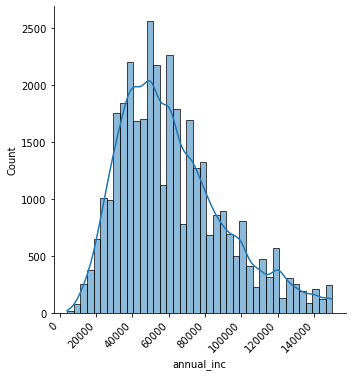

In [53]:
sns.displot(loan_analyse.annual_inc, bins=40, kde='reg')
plt.xticks(rotation=45,ha="right")
plt.show()

### From the below jointplot we observe that, none of the quantitative variables depend on each other except for the pair funded amount and installment which seems logical i.e. as the funded amount increases the emi for that funded amount also increases

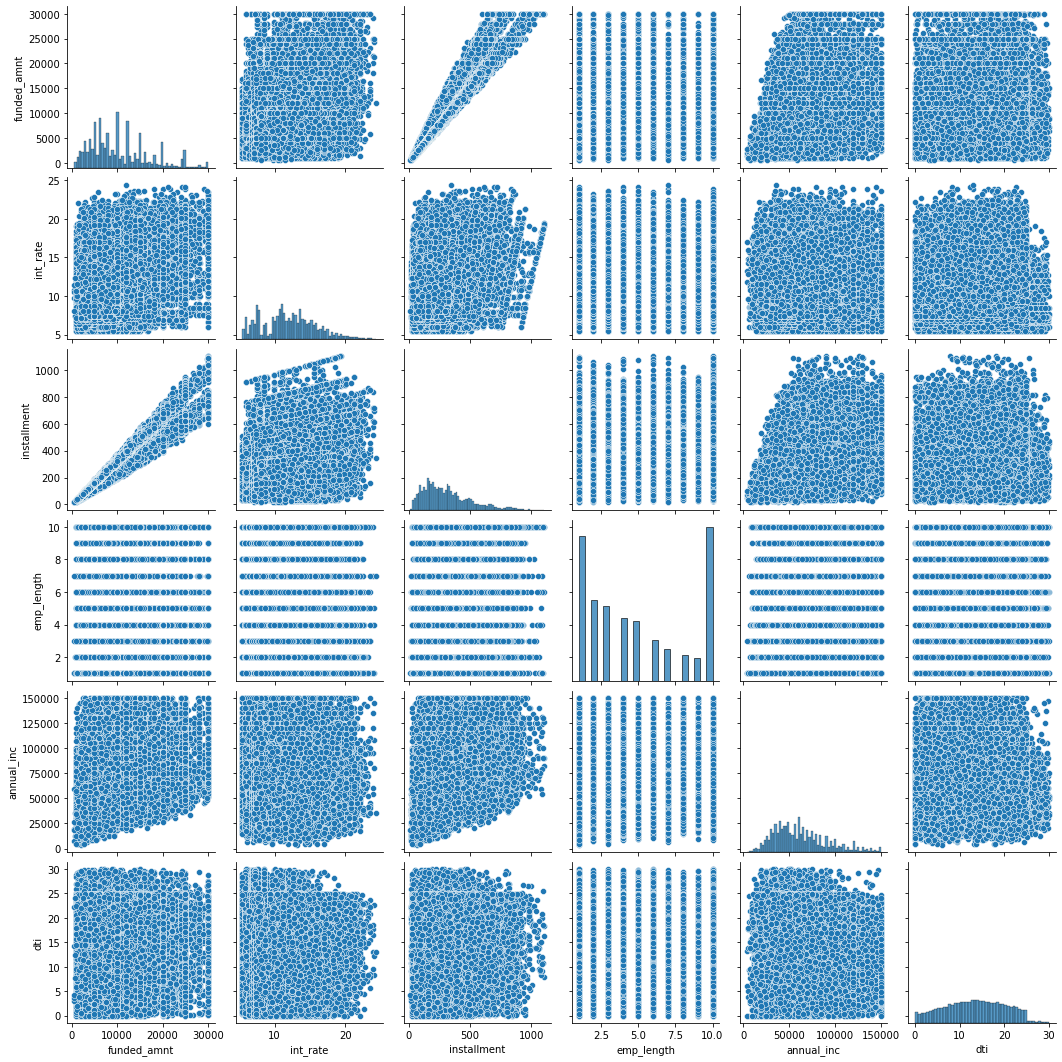

In [56]:
sns.pairplot(loan_analyse[['funded_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti']])

### Creating Pivot Tables of ordered variables, both by actual number and in terms of % and also checking their stacked representation

In [57]:
loan_volume_wise = pd.pivot_table(data=loan_analyse, index="loan_volume", columns="loan_status", values="annual_inc", aggfunc='count')
loan_volume_wise_perc = loan_volume_wise[['Fully Paid', 'Charged Off']].apply(lambda x: (x/x.sum())*100, axis=1)
display_side_by_side(loan_volume_wise,loan_volume_wise_perc, titles=['By Loan Volume','By Loan Volume in %'])

By Loan Volume 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 loan_volume 
 
 
 
 
 
 
 Small Loan 
 1228 
 7774 
 
 
 Medium Loan 
 1562 
 10777 
 
 
 Big Loan 
 1757 
 9660 
 
 
 Heavy Loan 
 547 
 2205 
 
 
 By Loan Volume in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 loan_volume 
 
 
 
 
 
 
 Small Loan 
 86.358587 
 13.641413 
 
 
 Medium Loan 
 87.340951 
 12.659049 
 
 
 Big Loan 
 84.610668 
 15.389332 
 
 
 Heavy Loan 
 80.123547 
 19.876453

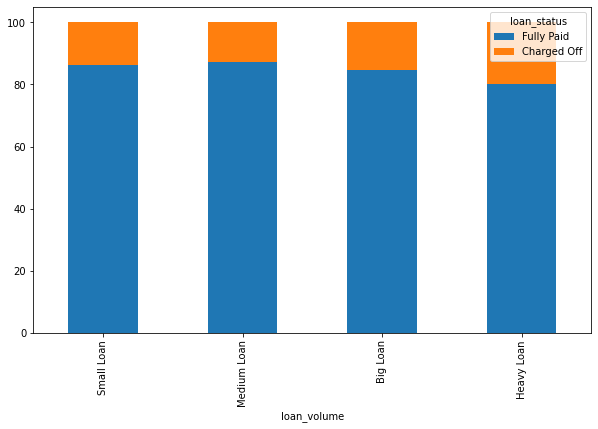

In [58]:
loan_volume_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [59]:
term_wise = pd.pivot_table(data=loan_analyse, index="term", columns="loan_status", values="annual_inc", aggfunc='count')
term_wise_perc = term_wise[['Fully Paid', 'Charged Off']].apply(lambda x: (x/x.sum())*100, axis=1)
display_side_by_side(term_wise,term_wise_perc, titles=['By Loan Term','By Loan Term in %'])

By Loan Term 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 term 
 
 
 
 
 
 
 36 months 
 2960 
 24068 
 
 
 60 months 
 2134 
 6348 
 
 
 By Loan Term in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 term 
 
 
 
 
 
 
 36 months 
 89.048394 
 10.951606 
 
 
 60 months 
 74.840839 
 25.159161

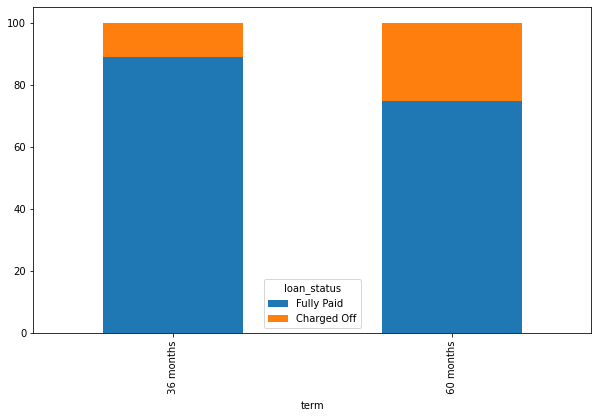

In [60]:
term_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [61]:
int_rate_wise = pd.pivot_table(data=loan_analyse, index="int_rate_group", columns="loan_status", values="annual_inc", aggfunc='count')
int_rate_wise_perc = int_rate_wise[['Fully Paid', 'Charged Off']].apply(lambda x: (x/x.sum())*100, axis=1)
display_side_by_side(int_rate_wise,int_rate_wise_perc, titles=['By Int Rate','By Int Rate in %'])

By Int Rate 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 int_rate_group 
 
 
 
 
 
 
 Low Int Rate 
 747 
 10656 
 
 
 Average Int Rate 
 2502 
 14485 
 
 
 High Int Rate 
 1608 
 4903 
 
 
 Very High Rate 
 237 
 372 
 
 
 By Int Rate in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 int_rate_group 
 
 
 
 
 
 
 Low Int Rate 
 93.449092 
 6.550908 
 
 
 Average Int Rate 
 85.271090 
 14.728910 
 
 
 High Int Rate 
 75.303333 
 24.696667 
 
 
 Very High Rate 
 61.083744 
 38.916256

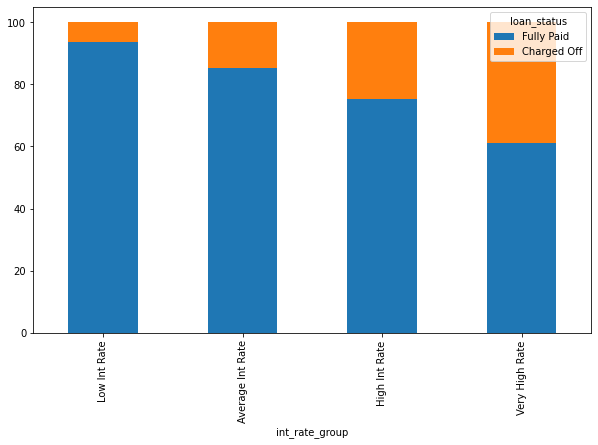

In [62]:
int_rate_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [63]:
emi_wise = pd.pivot_table(data=loan_analyse, index="emi_type", columns="loan_status", values="annual_inc", aggfunc='count')
emi_wise_perc = emi_wise[['Fully Paid', 'Charged Off']].apply(lambda x: (x/x.sum())*100, axis=1)
display_side_by_side(emi_wise,emi_wise_perc, titles=['By EMI','By EMI in %'])

By EMI 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 emi_type 
 
 
 
 
 
 
 Low EMI 
 554 
 3222 
 
 
 Moderate EMI 
 2142 
 13720 
 
 
 High EMI 
 940 
 5802 
 
 
 Very High EMI 
 1458 
 7672 
 
 
 By EMI in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 emi_type 
 
 
 
 
 
 
 Low EMI 
 85.328390 
 14.671610 
 
 
 Moderate EMI 
 86.496028 
 13.503972 
 
 
 High EMI 
 86.057550 
 13.942450 
 
 
 Very High EMI 
 84.030668 
 15.969332

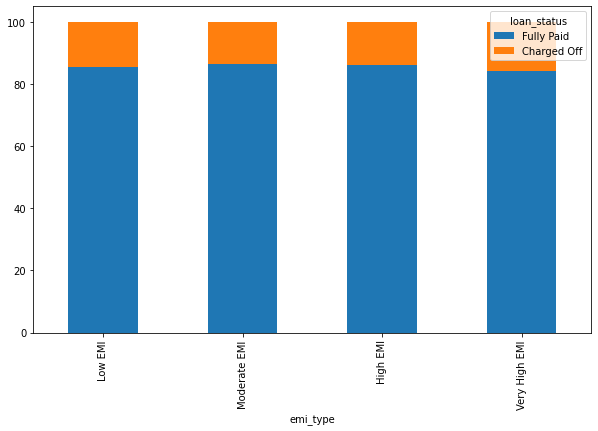

In [64]:
emi_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [65]:
grade_wise = pd.pivot_table(data=loan_analyse, index="grade", columns="loan_status", values="annual_inc", aggfunc='count')
grade_wise_perc = grade_wise[['Fully Paid', 'Charged Off']].apply(lambda x: (x/x.sum())*100, axis=1)
display_side_by_side(grade_wise,grade_wise_perc, titles=['By Grade','By Grade in %'])

By Grade 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 grade 
 
 
 
 
 
 
 A 
 551 
 8765 
 
 
 B 
 1296 
 9502 
 
 
 C 
 1247 
 6042 
 
 
 D 
 1031 
 3661 
 
 
 E 
 617 
 1720 
 
 
 F 
 265 
 562 
 
 
 G 
 87 
 164 
 
 
 By Grade in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 grade 
 
 
 
 
 
 
 A 
 94.085444 
 5.914556 
 
 
 B 
 87.997777 
 12.002223 
 
 
 C 
 82.892029 
 17.107971 
 
 
 D 
 78.026428 
 21.973572 
 
 
 E 
 73.598631 
 26.401369 
 
 
 F 
 67.956469 
 32.043531 
 
 
 G 
 65.338645 
 34.661355

##### It is clearly evident from below plot that, people with grades E, F, G end up in being defaulters as more than 25% of them do not pay their debts, with G being the highest 35%

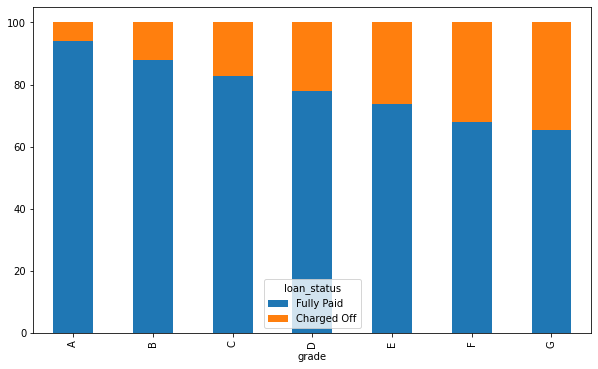

In [66]:
grade_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [67]:
exp_level_wise = pd.pivot_table(data=loan_analyse, index="exp_level", columns="loan_status", values="annual_inc", aggfunc='count')
exp_level_wise_perc = exp_level_wise[['Fully Paid', 'Charged Off']].apply(lambda x: (x/x.sum())*100, axis=1)
display_side_by_side(exp_level_wise,exp_level_wise_perc, titles=['By Exp Level','By Exp Level in %'])

By Exp Level 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 exp_level 
 
 
 
 
 
 
 Fresher 
 1596 
 9869 
 
 
 Intermediate 
 1398 
 8643 
 
 
 Experience 
 875 
 5318 
 
 
 Senior 
 1225 
 6586 
 
 
 By Exp Level in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 exp_level 
 
 
 
 
 
 
 Fresher 
 86.079372 
 13.920628 
 
 
 Intermediate 
 86.077084 
 13.922916 
 
 
 Experience 
 85.871145 
 14.128855 
 
 
 Senior 
 84.316989 
 15.683011

##### As per the below plot, it is visible that, the experience level does not play any role in being defaulters that is whatever is the experience level, 14 to 17 % of the people end up being defaulters in each experience level

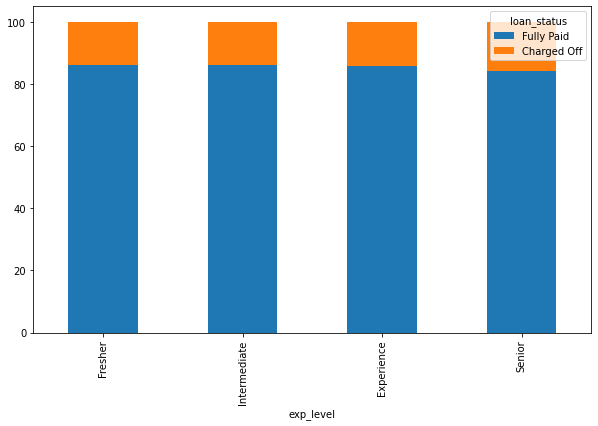

In [68]:
exp_level_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [69]:
income_wise = pd.pivot_table(data=loan_analyse, index="income_group", columns="loan_status", values="annual_inc", aggfunc='count')
income_wise_perc = income_wise[['Fully Paid', 'Charged Off']].apply(lambda x: (x/x.sum())*100, axis=1)
display_side_by_side(income_wise,income_wise_perc, titles=['By Income Group','By Income Group in %'])

By Income Group 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 income_group 
 
 
 
 
 
 
 Poor 
 750 
 3421 
 
 
 Lower Middle 
 2514 
 13377 
 
 
 Middle 
 1236 
 8536 
 
 
 Upper Middle 
 425 
 3688 
 
 
 Rich 
 169 
 1394 
 
 
 By Income Group in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 income_group 
 
 
 
 
 
 
 Poor 
 82.018701 
 17.981299 
 
 
 Lower Middle 
 84.179724 
 15.820276 
 
 
 Middle 
 87.351617 
 12.648383 
 
 
 Upper Middle 
 89.666910 
 10.333090 
 
 
 Rich 
 89.187460 
 10.812540

##### Fromt the below plot, it looks like, almost 20% people who have annual income less than or equal to USD30000 end up being defaulters. Also out of people who earn more than USD9000 annually, more than 90% end up paying their dues eventually

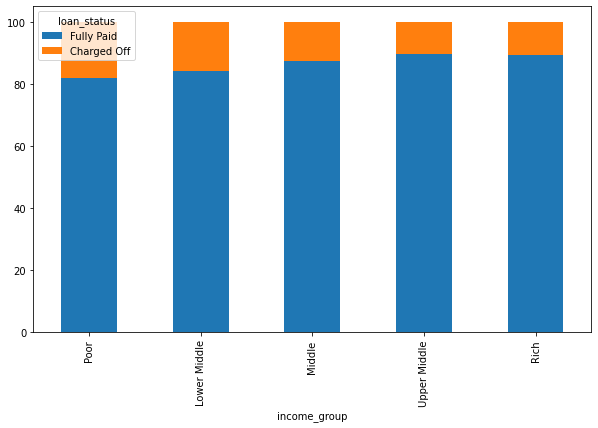

In [70]:
income_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [71]:
verification_wise = pd.pivot_table(data=loan_analyse, index="verification_status", columns="loan_status", values="annual_inc", aggfunc='count')
verification_wise_perc = verification_wise[['Fully Paid', 'Charged Off']].apply(lambda x: (x/x.sum())*100, axis=1)
display_side_by_side(verification_wise,verification_wise_perc, titles=['By Verification Status','By Verification Status %'])

By Verification Status 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 verification_status 
 
 
 
 
 
 
 Not Verified 
 2005 
 13920 
 
 
 Source Verified 
 1334 
 7689 
 
 
 Verified 
 1755 
 8807 
 
 
 By Verification Status % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 verification_status 
 
 
 
 
 
 
 Not Verified 
 87.409733 
 12.590267 
 
 
 Source Verified 
 85.215560 
 14.784440 
 
 
 Verified 
 83.383829 
 16.616171

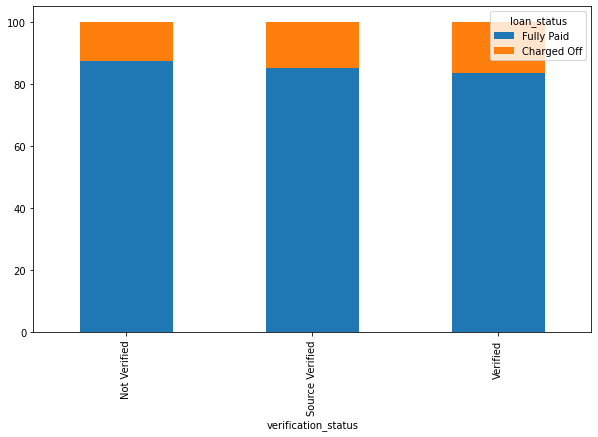

In [72]:
verification_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [73]:
issue_month_wise = pd.pivot_table(data=loan_analyse, values="annual_inc", index=loan_analyse.issue_d.dt.month, columns="loan_status", aggfunc='count')
issue_month_perc_wise = issue_month_wise[['Fully Paid', 'Charged Off']].apply(lambda x: x/x.sum(), axis=1)
display_side_by_side(issue_month_wise,issue_month_perc_wise, titles=['by Loan Issue Month','by Loan Issue Month in %'])

by Loan Issue Month 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 issue_d 
 
 
 
 
 
 
 1 
 298 
 1938 
 
 
 2 
 253 
 1916 
 
 
 3 
 318 
 2174 
 
 
 4 
 331 
 2274 
 
 
 5 
 427 
 2280 
 
 
 6 
 432 
 2497 
 
 
 7 
 438 
 2650 
 
 
 8 
 431 
 2707 
 
 
 9 
 501 
 2676 
 
 
 10 
 509 
 2862 
 
 
 11 
 533 
 3139 
 
 
 12 
 623 
 3303 
 
 
 by Loan Issue Month in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 issue_d 
 
 
 
 
 
 
 1 
 0.866726 
 0.133274 
 
 
 2 
 0.883356 
 0.116644 
 
 
 3 
 0.872392 
 0.127608 
 
 
 4 
 0.872937 
 0.127063 
 
 
 5 
 0.842261 
 0.157739 
 
 
 6 
 0.852509 
 0.147491 
 
 
 7 
 0.858161 
 0.141839 
 
 
 8 
 0.862651 
 0.137349 
 
 
 9 
 0.842304 
 0.157696 
 
 
 10 
 0.849006 
 0.150994 
 
 
 11 
 0.854847 
 0.145153 
 
 
 12 
 0.841314 
 0.158686

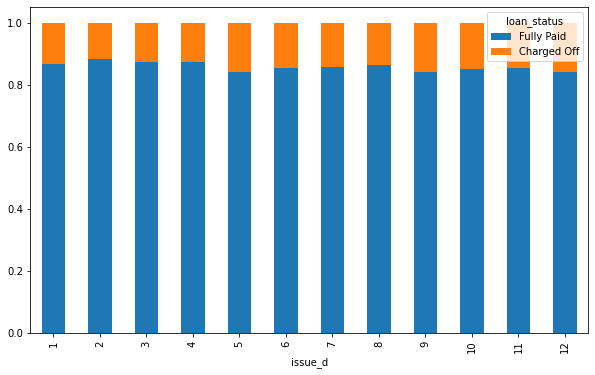

In [74]:
issue_month_perc_wise.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [75]:
dti_wise = pd.pivot_table(data=loan_analyse, index="debt_profile", columns="loan_status", values="annual_inc", aggfunc='count')
dti_wise_perc = dti_wise[['Fully Paid', 'Charged Off']].apply(lambda x: (x/x.sum())*100, axis=1)
display_side_by_side(dti_wise,dti_wise_perc, titles=['By Debt Profile','By Debt Profile in %'])

By Debt Profile 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 debt_profile 
 
 
 
 
 
 
 Very Low Debt 
 563 
 3934 
 
 
 Low Debt 
 894 
 6174 
 
 
 Moderate Debt 
 1272 
 7624 
 
 
 High Debt 
 1262 
 6998 
 
 
 Very High Debt 
 1103 
 5686 
 
 
 By Debt Profile in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 debt_profile 
 
 
 
 
 
 
 Very Low Debt 
 87.480543 
 12.519457 
 
 
 Low Debt 
 87.351443 
 12.648557 
 
 
 Moderate Debt 
 85.701439 
 14.298561 
 
 
 High Debt 
 84.721550 
 15.278450 
 
 
 Very High Debt 
 83.753130 
 16.246870

##### It is seen from below plot that, more than 15% of people of dti of more than 15% end up being defaulters

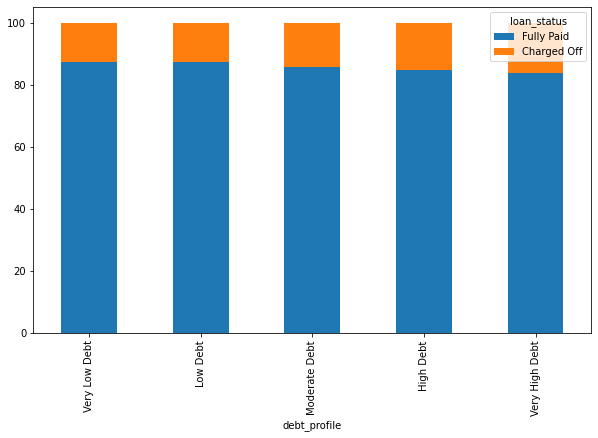

In [76]:
dti_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

### Creating Pivot Tables of un-ordered variables, both by actual number and in terms of %

In [77]:
own_home_wise = pd.pivot_table(data=loan_analyse, index="home_ownership", columns="loan_status", values="annual_inc", aggfunc='count')
own_home_wise_perc = own_home_wise[['Fully Paid', 'Charged Off']].apply(lambda x: (x/x.sum())*100, axis=1)
display_side_by_side(own_home_wise,own_home_wise_perc, titles=['By Home Ownership','By Home Ownership in %'])

By Home Ownership 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 home_ownership 
 
 
 
 
 
 
 MORTGAGE 
 2054 
 13192 
 
 
 OWN 
 390 
 2260 
 
 
 RENT 
 2650 
 14964 
 
 
 By Home Ownership in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 home_ownership 
 
 
 
 
 
 
 MORTGAGE 
 86.527614 
 13.472386 
 
 
 OWN 
 85.283019 
 14.716981 
 
 
 RENT 
 84.955149 
 15.044851

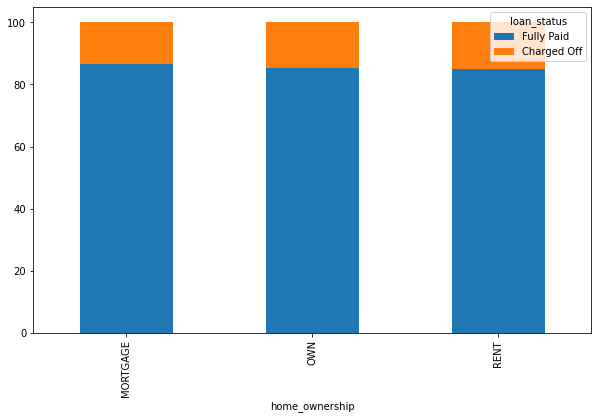

In [78]:
own_home_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [79]:
purpose_wise = pd.pivot_table(data=loan_analyse, values="annual_inc", index=loan_analyse.purpose, columns="loan_status", aggfunc='count')
purpose_wise_perc = purpose_wise[['Fully Paid', 'Charged Off']].apply(lambda x: x/x.sum(), axis=1)
display_side_by_side(purpose_wise,purpose_wise_perc, titles=['By Purpose','By Purpose in %'])

By Purpose 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 purpose 
 
 
 
 
 
 
 car 
 153 
 1260 
 
 
 credit_card 
 483 
 4175 
 
 
 debt_consolidation 
 2527 
 14253 
 
 
 educational 
 51 
 252 
 
 
 home_improvement 
 300 
 2191 
 
 
 house 
 53 
 272 
 
 
 major_purchase 
 206 
 1777 
 
 
 medical 
 98 
 523 
 
 
 moving 
 81 
 449 
 
 
 other 
 566 
 2973 
 
 
 renewable_energy 
 17 
 69 
 
 
 small_business 
 421 
 1135 
 
 
 vacation 
 49 
 291 
 
 
 wedding 
 89 
 796 
 
 
 By Purpose in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 purpose 
 
 
 
 
 
 
 car 
 0.891720 
 0.108280 
 
 
 credit_card 
 0.896307 
 0.103693 
 
 
 debt_consolidation 
 0.849404 
 0.150596 
 
 
 educational 
 0.831683 
 0.168317 
 
 
 home_improvement 
 0.879566 
 0.120434 
 
 
 house 
 0.836923 
 0.163077 
 
 
 major_purchase 
 0.896117 
 0.103883 
 
 
 medical 
 0.842190 
 0.157810 
 
 
 moving 
 0.847170 
 0.152830 
 
 
 other 
 0.840068 
 0.159932 
 
 
 renewable_energy 
 0.802326 
 0.197674 
 
 
 small_business 
 0.729434 
 0.270566 
 
 
 vacation 
 0.855882 
 0.144118 
 
 
 wedding 
 0.899435 
 0.100565

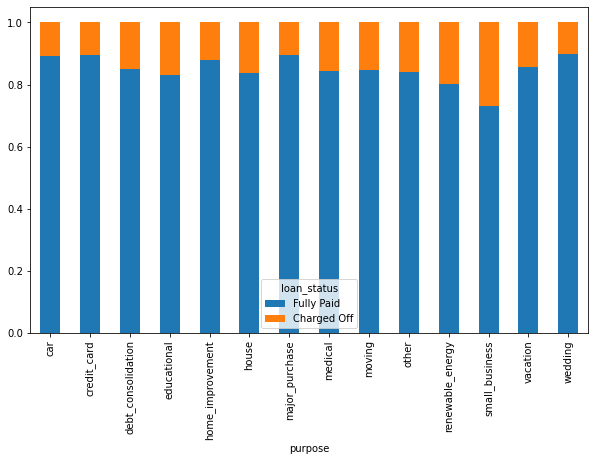

In [80]:
purpose_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [81]:
region_wise = pd.pivot_table(data=loan_analyse, values="annual_inc", index="state_region", columns="loan_status", aggfunc='count')
region_wise_perc = region_wise[['Fully Paid', 'Charged Off']].apply(lambda x: x/x.sum(), axis=1)
display_side_by_side(region_wise,region_wise_perc, titles=['By Region','By Region in %'])

By Region 
 
 
 loan_status 
 Charged Off 
 Fully Paid 
 
 
 state_region 
 
 
 
 
 
 
 Midwest 
 688 
 4314 
 
 
 Northeast 
 1147 
 7482 
 
 
 South 
 1667 
 9976 
 
 
 West 
 1592 
 8644 
 
 
 By Region in % 
 
 
 loan_status 
 Fully Paid 
 Charged Off 
 
 
 state_region 
 
 
 
 
 
 
 Midwest 
 0.862455 
 0.137545 
 
 
 Northeast 
 0.867076 
 0.132924 
 
 
 South 
 0.856824 
 0.143176 
 
 
 West 
 0.844470 
 0.155530

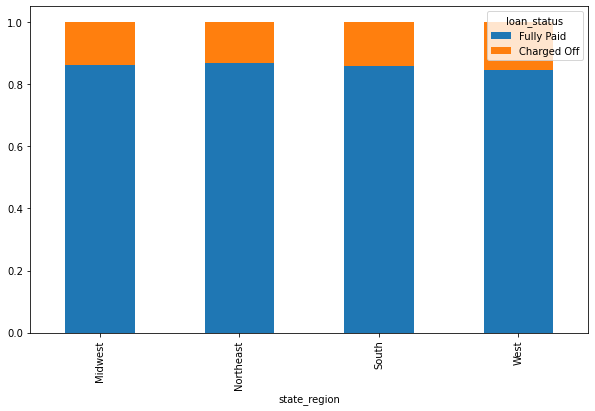

In [82]:
region_wise_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.show()

In [84]:
# Creating two dataframes of charged off and full paid users which will be used in our further analysis
charged_off = loan_analyse[loan_analyse.loan_status == "Charged Off"]
fully_paid = loan_analyse[loan_analyse.loan_status == "Fully Paid"]

## Analyzing Home Ownership with others

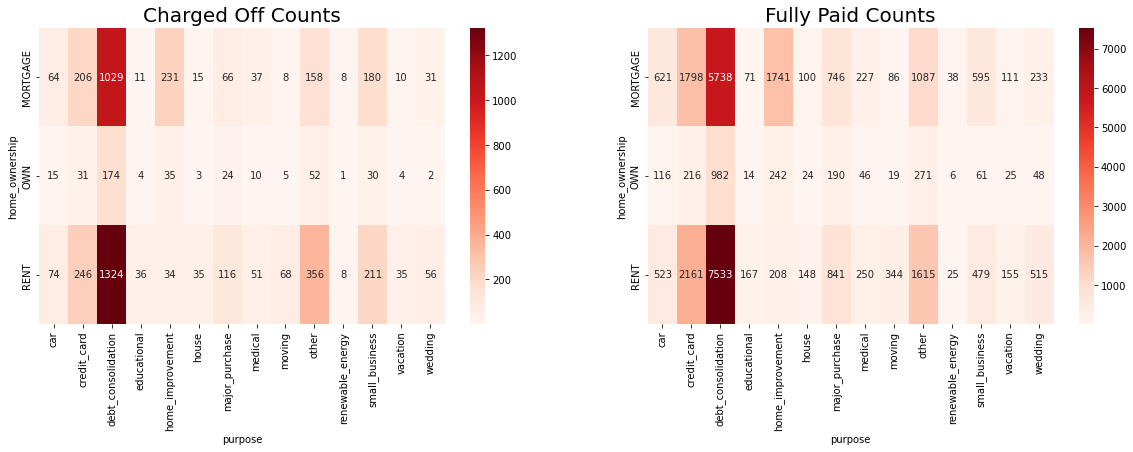

In [85]:
# for any kind of loan people take, whether they own house or not, it does not tell if they will become defaulters or not
ownedhome_purpose_charged_off_HM = pd.pivot_table(data=charged_off,index="home_ownership",columns="purpose",values="loan_status",aggfunc='count')
ownedhome_purpose_fully_paid_HM = pd.pivot_table(data=fully_paid,index="home_ownership",columns="purpose",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(ownedhome_purpose_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(ownedhome_purpose_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

# Note: While analyzing these heatmaps we have deliberately kept same colors to both heatmaps.
#       We are observing if from right to left the particular cell has been darker or lighter in shade.
#       So, if the left cell is lighter than respective right cell or if left cell is having same shade as right cell,
#           then we assume that the trend is similar in both these cases 
#           i.e. if charged-off are more then fully-paid also are more
#       But if the left cell is significantly darker than respective right cell, 
#           then it indicates that left side % (i.e. charged-off %) is significantly more than that of fully-paid
# All the analysis that is based upon HeatMaps is using above understanding

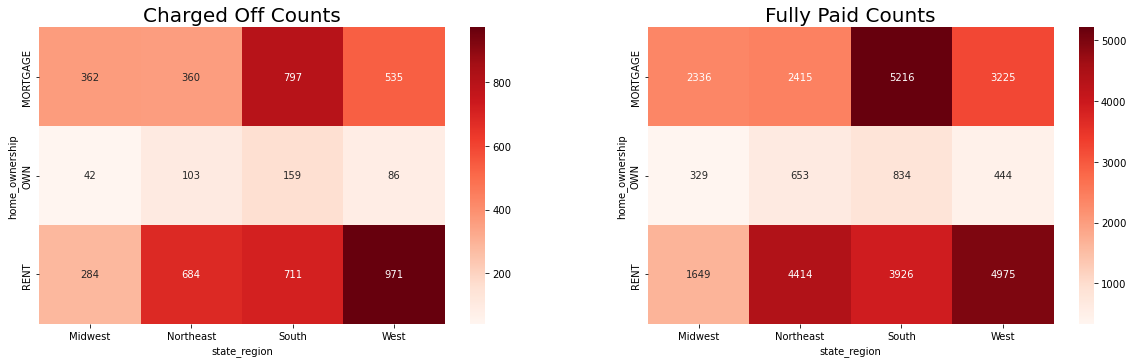

In [86]:
# Across US, whether people own house or not, it does not tell if they will become defaulters or not
ownedhome_region_charged_off_HM = pd.pivot_table(data=charged_off,index="home_ownership",columns="state_region",values="loan_status",aggfunc='count')
ownedhome_region_fully_paid_HM = pd.pivot_table(data=fully_paid,index="home_ownership",columns="state_region",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(ownedhome_region_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(ownedhome_region_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

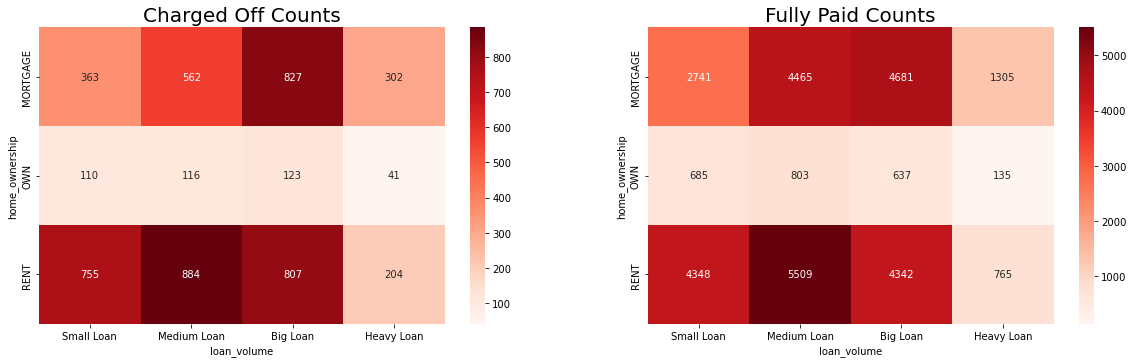

In [87]:
# While people who have owned house are safe to give any kind of loan. But when it comes to people who stay on rent or who have
# their house as mortgage, it is possible that such people with loan amount of more than USD10k may end of being defaulters
ownedhome_loanvol_charged_off_HM = pd.pivot_table(data=charged_off,index="home_ownership",columns="loan_volume",values="loan_status",aggfunc='count')
ownedhome_loanvol_fully_paid_HM = pd.pivot_table(data=fully_paid,index="home_ownership",columns="loan_volume",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(ownedhome_loanvol_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(ownedhome_loanvol_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

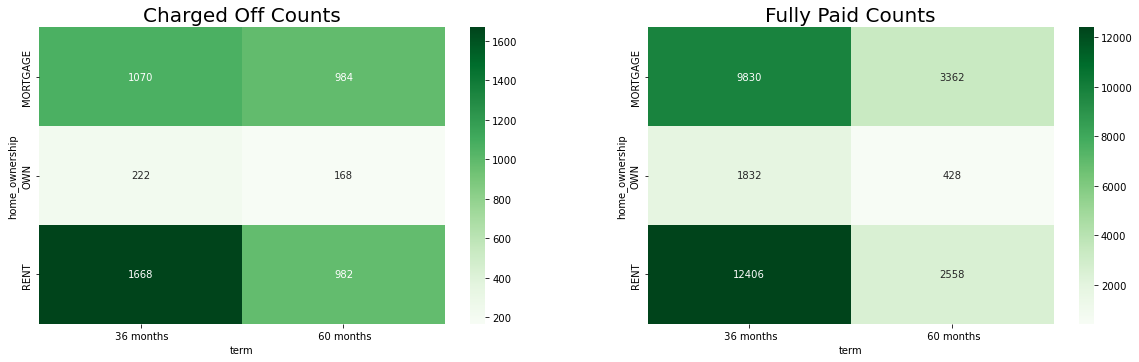

In [151]:
# While people who have owned house are safe to give loan for any tenure. But when it comes to people who stay on rent or who have
# their house as mortgage, it is possible that such people with tenure of 5 years may end of being defaulters
ownedhome_term_charged_off_HM = pd.pivot_table(data=charged_off,index="home_ownership",columns="term",values="loan_status",aggfunc='count')
ownedhome_term_fully_paid_HM = pd.pivot_table(data=fully_paid,index="home_ownership",columns="term",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(ownedhome_term_charged_off_HM, cmap = "Greens", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(ownedhome_term_fully_paid_HM, cmap = "Greens", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

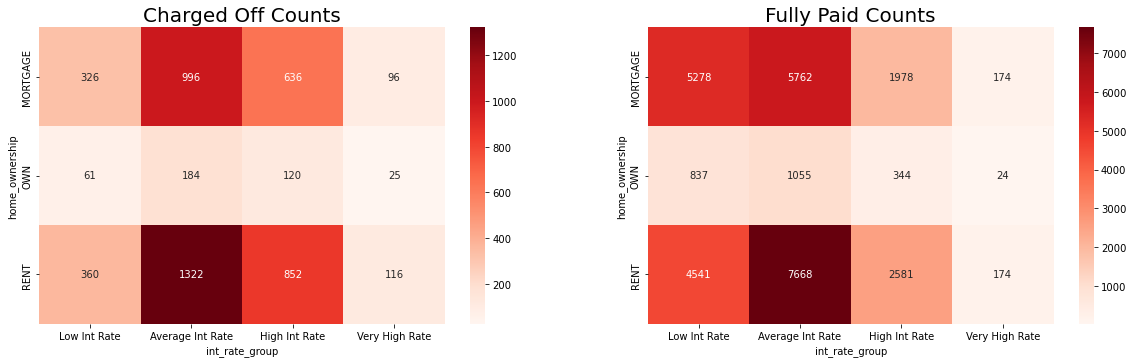

In [89]:
# for all interest rates, whether people own house or not, we cannot tell if they will become defaulters or not
ownedhome_int_charged_off_HM = pd.pivot_table(data=charged_off,index="home_ownership",columns="int_rate_group",values="loan_status",aggfunc='count')
ownedhome_int_fully_paid_HM = pd.pivot_table(data=fully_paid,index="home_ownership",columns="int_rate_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(ownedhome_int_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(ownedhome_int_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

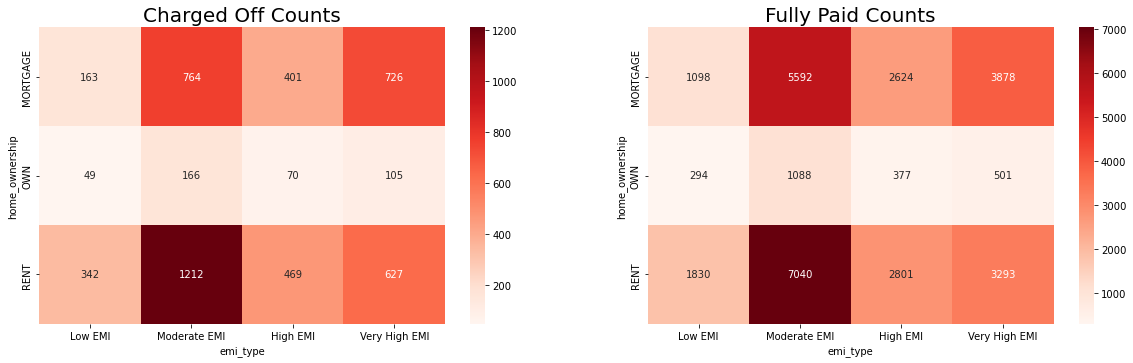

In [90]:
# For people who are staying on rent or who have their house on mortgage, it turns out that EMI of more than 300 is an extra 
# burden so they end up being defaulters

ownedhome_emi_charged_off_HM = pd.pivot_table(data=charged_off,index="home_ownership",columns="emi_type",values="loan_status",aggfunc='count')
ownedhome_emi_fully_paid_HM = pd.pivot_table(data=fully_paid,index="home_ownership",columns="emi_type",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(ownedhome_emi_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(ownedhome_emi_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

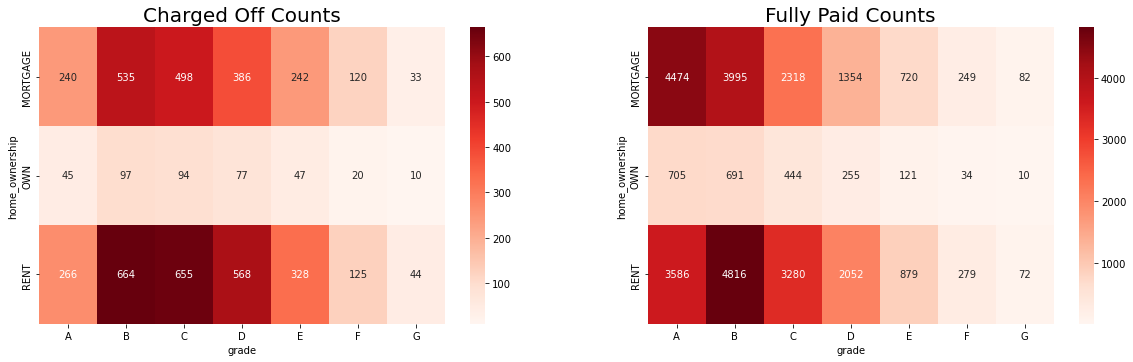

In [91]:
# For people who are staying on rent or who have their house on mortgage, it turns out that if they are in grade C, D or E
# they end up being defaulters

ownedhome_grade_charged_off_HM = pd.pivot_table(data=charged_off,index="home_ownership",columns="grade",values="loan_status",aggfunc='count')
ownedhome_grade_fully_paid_HM = pd.pivot_table(data=fully_paid,index="home_ownership",columns="grade",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(ownedhome_grade_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(ownedhome_grade_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

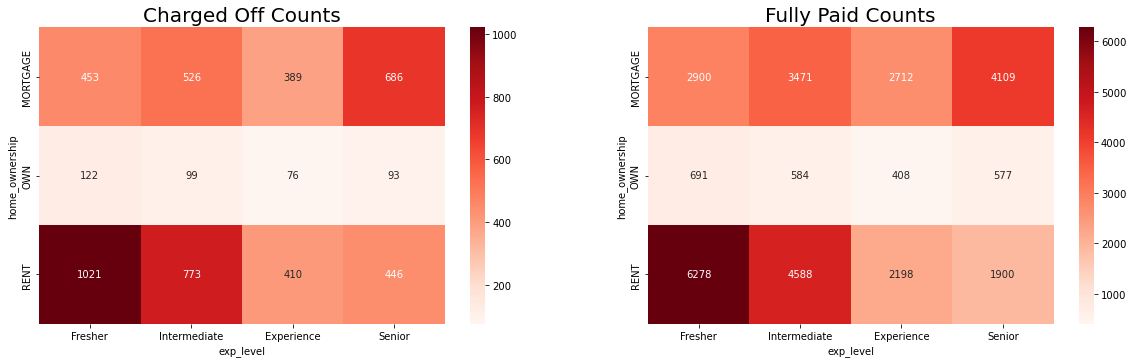

In [92]:
# For people who are staying on rent or who have their house on mortgage, we cannot tell if they will become defaulters or not
# by looking at their experience

ownedhome_exp_charged_off_HM = pd.pivot_table(data=charged_off,index="home_ownership",columns="exp_level",values="loan_status",aggfunc='count')
ownedhome_exp_fully_paid_HM = pd.pivot_table(data=fully_paid,index="home_ownership",columns="exp_level",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(ownedhome_exp_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(ownedhome_exp_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

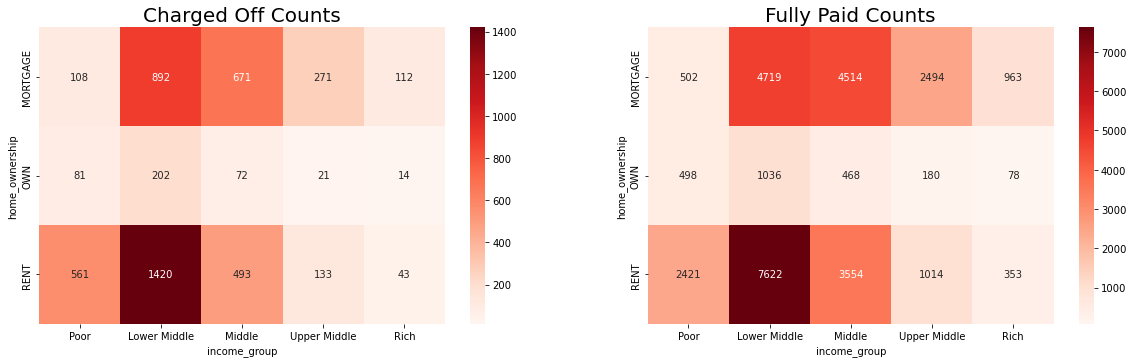

In [93]:
# For people who are staying on rent or who have their house on mortgage, we cannot tell if they will become defaulters or not
# by looking at annual income

ownedhome_inc_charged_off_HM = pd.pivot_table(data=charged_off,index="home_ownership",columns="income_group",values="loan_status",aggfunc='count')
ownedhome_inc_fully_paid_HM = pd.pivot_table(data=fully_paid,index="home_ownership",columns="income_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(ownedhome_inc_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(ownedhome_inc_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

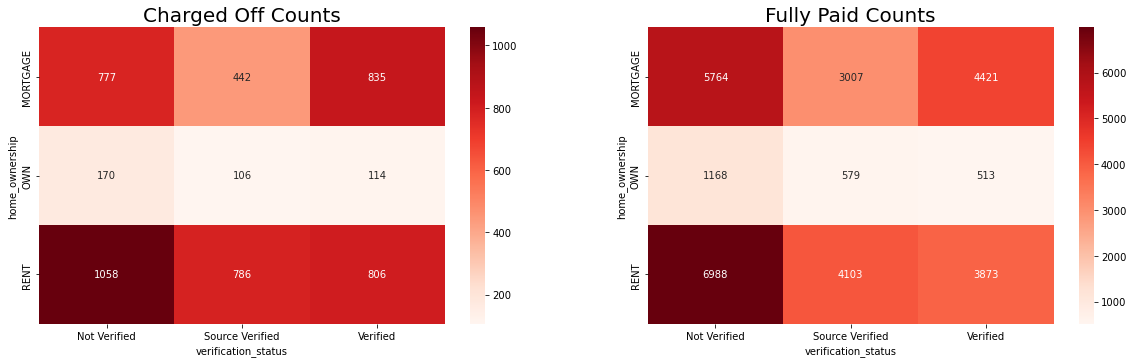

In [94]:
# For people who are staying on rent or who have their house on mortgage, income source may need to be verified as
# as their income may not be genuine and just verified end up being defaulters

ownedhome_verify_charged_off_HM = pd.pivot_table(data=charged_off,index="home_ownership",columns="verification_status",values="loan_status",aggfunc='count')
ownedhome_verify_fully_paid_HM = pd.pivot_table(data=fully_paid,index="home_ownership",columns="verification_status",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(ownedhome_verify_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(ownedhome_verify_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

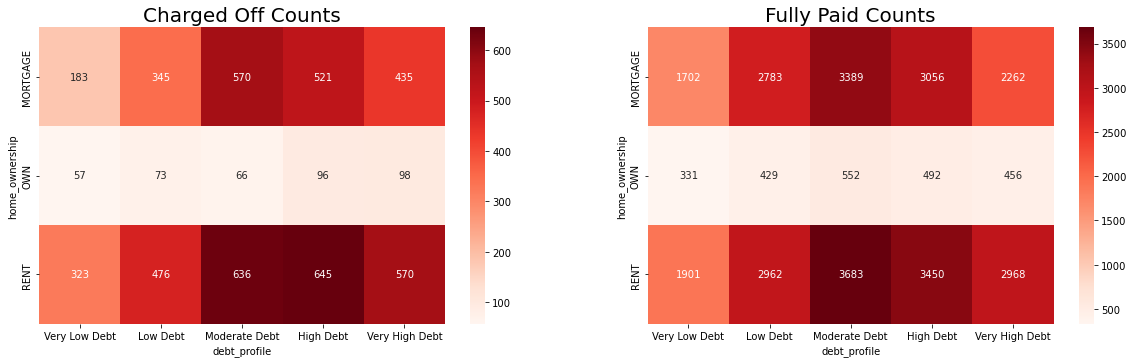

In [95]:
# For people who are staying on rent, if their dti is between 15 and 20, they more likely become defaulters

ownedhome_dti_charged_off_HM = pd.pivot_table(data=charged_off,index="home_ownership",columns="debt_profile",values="loan_status",aggfunc='count')
ownedhome_dti_fully_paid_HM = pd.pivot_table(data=fully_paid,index="home_ownership",columns="debt_profile",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(ownedhome_dti_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(ownedhome_dti_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

## Analyzing Purpose with others

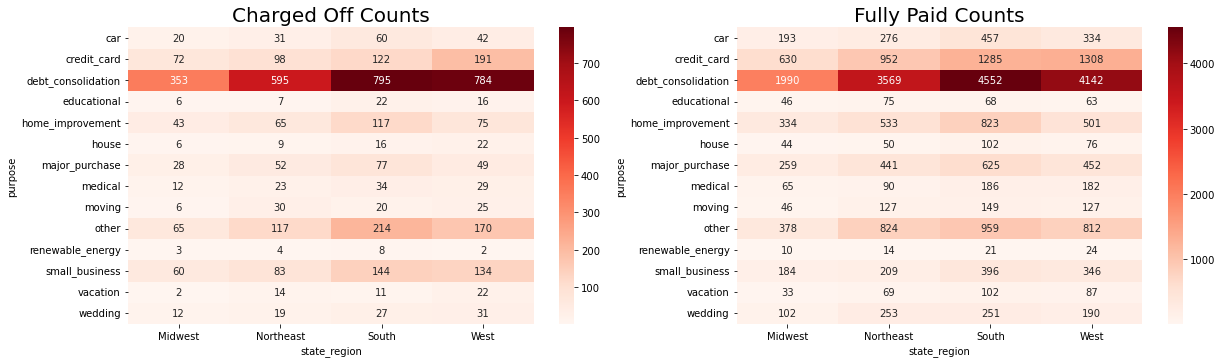

In [96]:
# for any purpose people take loan, it does not tell if they will become defaulters or not based upon their region
purpose_region_charged_off_HM = pd.pivot_table(data=charged_off,index="purpose",columns="state_region",values="loan_status",aggfunc='count')
purpose_region_fully_paid_HM = pd.pivot_table(data=fully_paid,index="purpose",columns="state_region",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(purpose_region_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(purpose_region_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

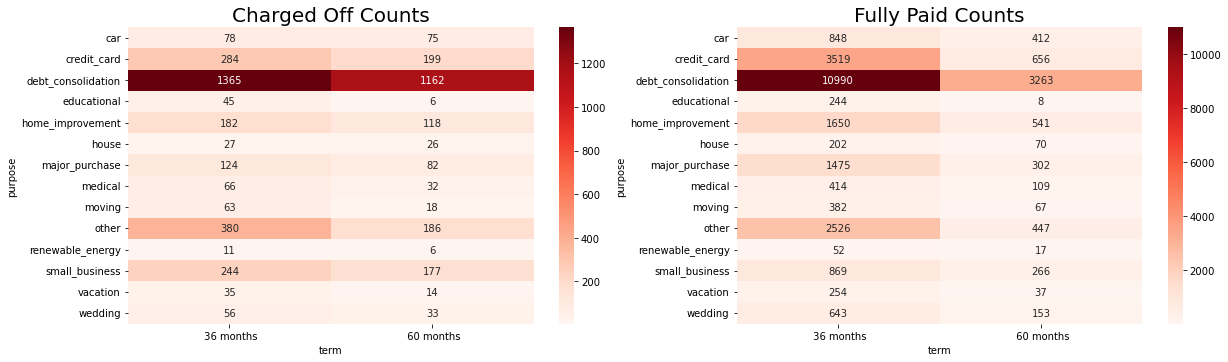

In [97]:
# for any purpose people take loan, it does not tell if they will become defaulters or not based upon their region
purpose_loanvol_charged_off_HM = pd.pivot_table(data=charged_off,index="purpose",columns="term",values="loan_status",aggfunc='count')
purpose_loanvol_fully_paid_HM = pd.pivot_table(data=fully_paid,index="purpose",columns="term",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(purpose_loanvol_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(purpose_loanvol_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

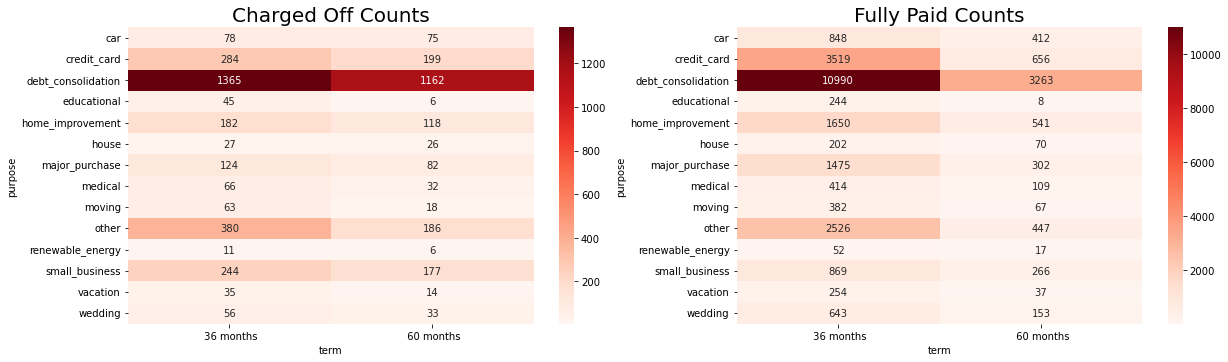

In [98]:
# for any purpose people take loan, it does not tell if they will become defaulters or not based upon their region
purpose_term_charged_off_HM = pd.pivot_table(data=charged_off,index="purpose",columns="term",values="loan_status",aggfunc='count')
purpose_term_fully_paid_HM = pd.pivot_table(data=fully_paid,index="purpose",columns="term",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(purpose_term_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(purpose_term_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

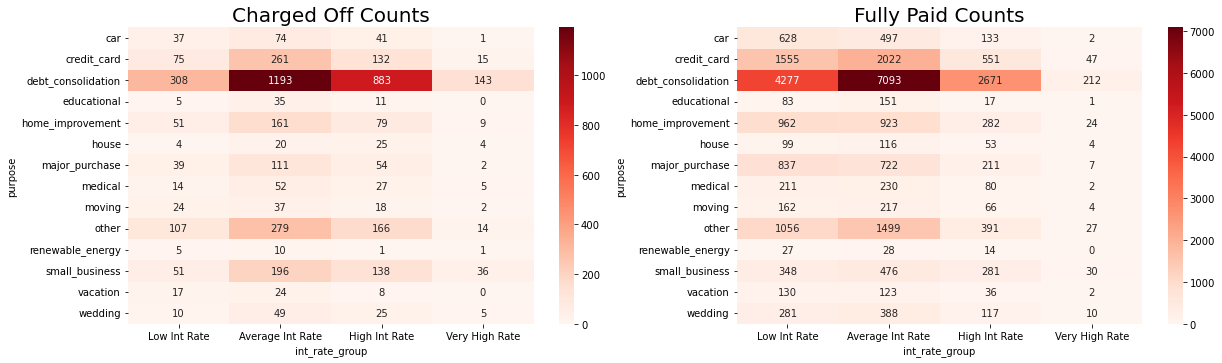

In [99]:
# for any purpose people take loan, it does not tell if they will become defaulters or not based upon their region
purpose_int_charged_off_HM = pd.pivot_table(data=charged_off,index="purpose",columns="int_rate_group",values="loan_status",aggfunc='count')
purpose_int_fully_paid_HM = pd.pivot_table(data=fully_paid,index="purpose",columns="int_rate_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(purpose_int_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(purpose_int_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

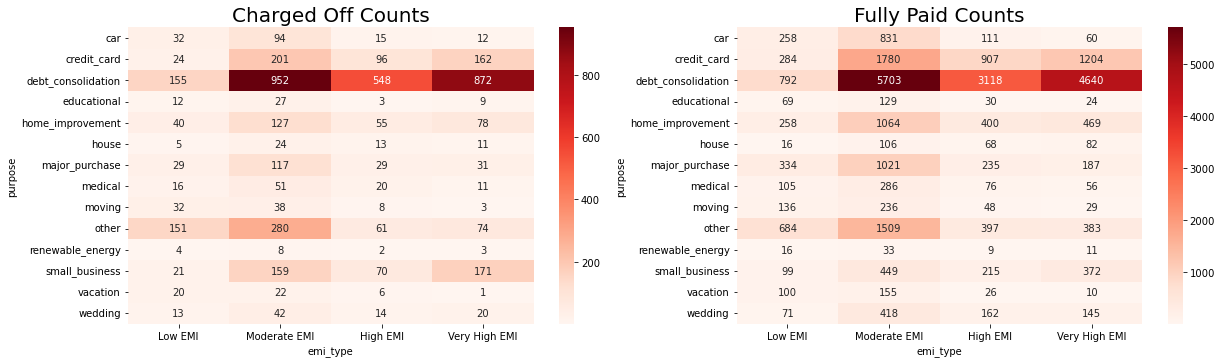

In [100]:
# for debt_consolidation type of loans, people with EMI more than USD300 end up in becoming defaulters
purpose_emi_charged_off_HM = pd.pivot_table(data=charged_off,index="purpose",columns="emi_type",values="loan_status",aggfunc='count')
purpose_emi_fully_paid_HM = pd.pivot_table(data=fully_paid,index="purpose",columns="emi_type",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(purpose_emi_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(purpose_emi_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

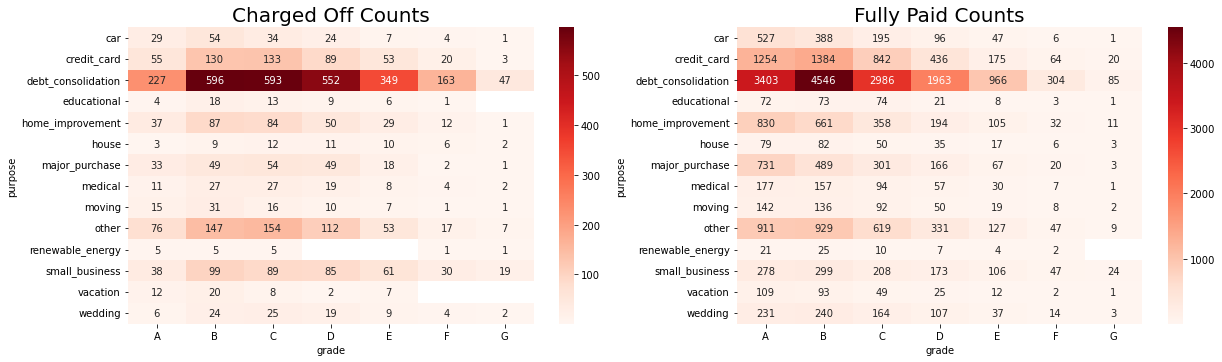

In [101]:
# for debt_consolidation type of loans, people who have grades C, D, E, F may end up in becoming defaulters.
purpose_grade_charged_off_HM = pd.pivot_table(data=charged_off,index="purpose",columns="grade",values="loan_status",aggfunc='count')
purpose_grade_fully_paid_HM = pd.pivot_table(data=fully_paid,index="purpose",columns="grade",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(purpose_grade_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(purpose_grade_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

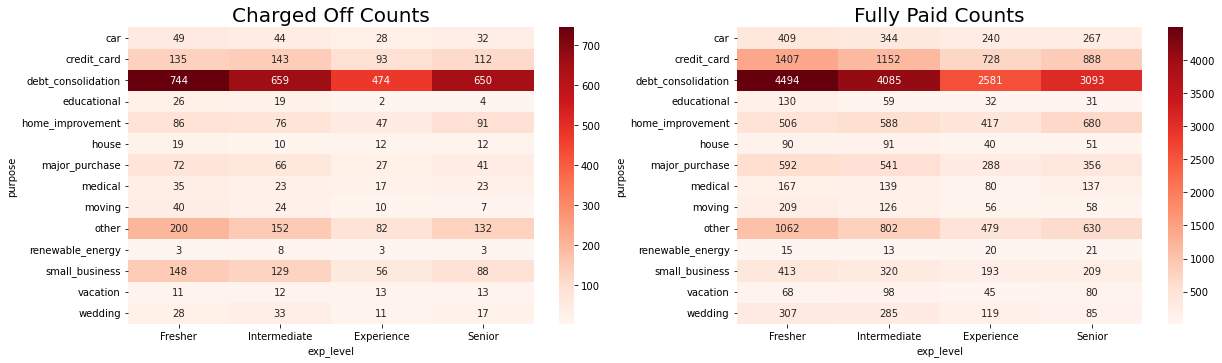

In [102]:
# People with no or very less experience who go for small-business loans have a tendency to become defaulters

purpose_exp_charged_off_HM = pd.pivot_table(data=charged_off,index="purpose",columns="exp_level",values="loan_status",aggfunc='count')
purpose_exp_fully_paid_HM = pd.pivot_table(data=fully_paid,index="purpose",columns="exp_level",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(purpose_exp_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(purpose_exp_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

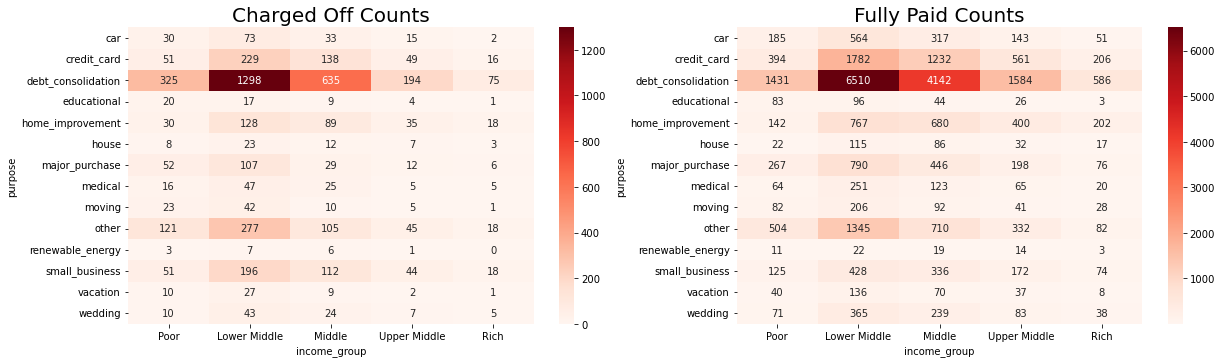

In [103]:
purpose_inc_charged_off_HM = pd.pivot_table(data=charged_off,index="purpose",columns="income_group",values="loan_status",aggfunc='count')
purpose_inc_fully_paid_HM = pd.pivot_table(data=fully_paid,index="purpose",columns="income_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(purpose_inc_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(purpose_inc_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

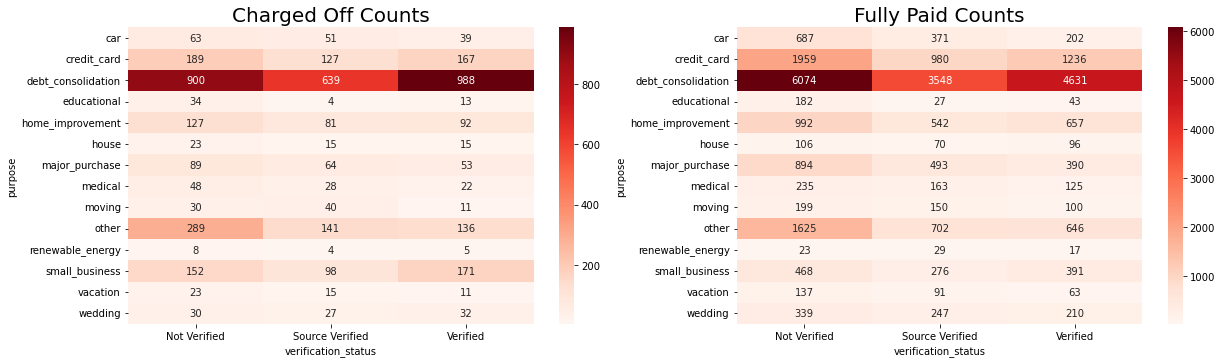

In [104]:
# people who take loans for small business, if their income source is not verified then they may become defaulters
purpose_verify_charged_off_HM = pd.pivot_table(data=charged_off,index="purpose",columns="verification_status",values="loan_status",aggfunc='count')
purpose_verify_fully_paid_HM = pd.pivot_table(data=fully_paid,index="purpose",columns="verification_status",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(purpose_verify_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(purpose_verify_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

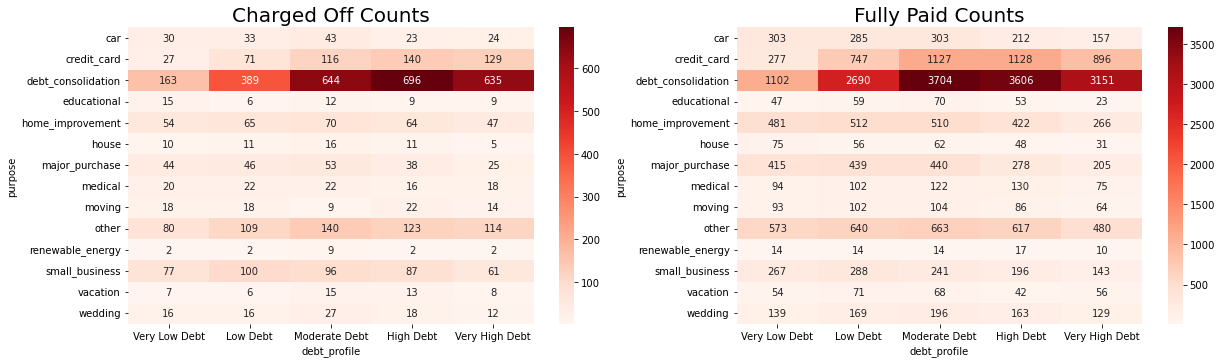

In [105]:
# look at dti parameter when giving loans to people for small-business. For other types, dti shows no dependency
purpose_dti_charged_off_HM = pd.pivot_table(data=charged_off,index="purpose",columns="debt_profile",values="loan_status",aggfunc='count')
purpose_dti_fully_paid_HM = pd.pivot_table(data=fully_paid,index="purpose",columns="debt_profile",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(purpose_dti_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(purpose_dti_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

## Analyzing State Region with others

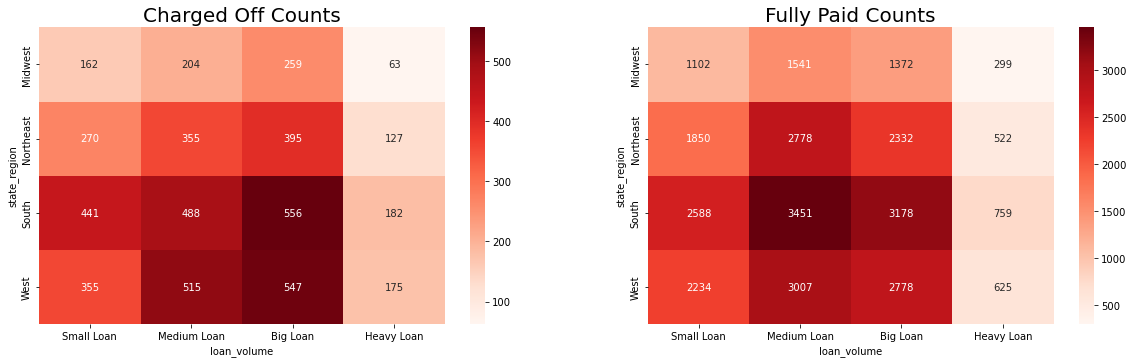

In [106]:
# West Region people who take loans more than USD5k and South region people who take loans more than USD10k
# more likely become defaulters
region_loanvol_charged_off_HM = pd.pivot_table(data=charged_off,index="state_region",columns="loan_volume",values="loan_status",aggfunc='count')
region_loanvol_fully_paid_HM = pd.pivot_table(data=fully_paid,index="state_region",columns="loan_volume",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(region_loanvol_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(region_loanvol_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

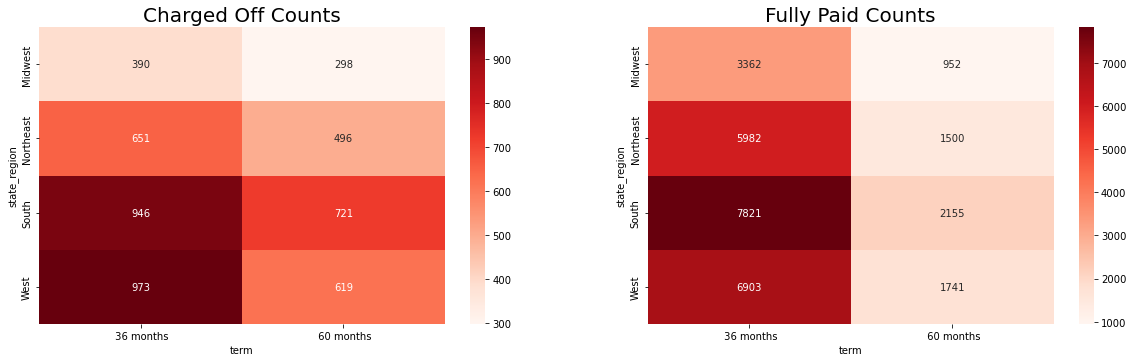

In [107]:
# Irrespective of region, people who take loans for 5 years have more tendency to default
# Additionally people from West region who take loan for 3 years also become defaulters
region_int_charged_off_HM = pd.pivot_table(data=charged_off,index="state_region",columns="term",values="loan_status",aggfunc='count')
region_int_fully_paid_HM = pd.pivot_table(data=fully_paid,index="state_region",columns="term",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(region_int_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(region_int_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

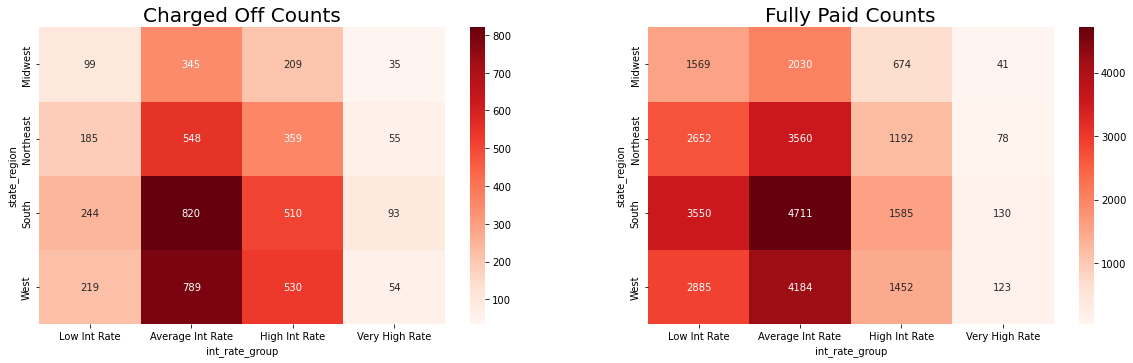

In [108]:
# Irrespective of people's region, people having interest rate of 15% and more result into being defaulters
region_int_charged_off_HM = pd.pivot_table(data=charged_off,index="state_region",columns="int_rate_group",values="loan_status",aggfunc='count')
region_int_fully_paid_HM = pd.pivot_table(data=fully_paid,index="state_region",columns="int_rate_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(region_int_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(region_int_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

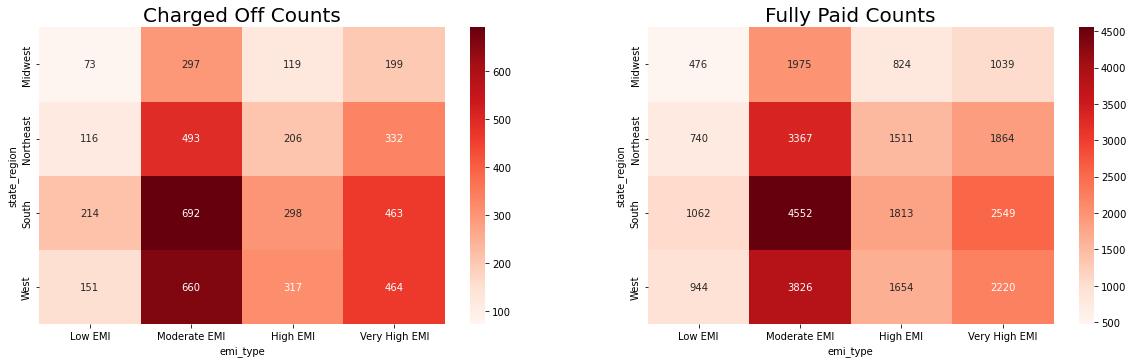

In [109]:
# Irrespective of people's region, people having EMI more than USD300 end up being defaulters
region_emi_charged_off_HM = pd.pivot_table(data=charged_off,index="state_region",columns="emi_type",values="loan_status",aggfunc='count')
region_emi_fully_paid_HM = pd.pivot_table(data=fully_paid,index="state_region",columns="emi_type",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(region_emi_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(region_emi_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

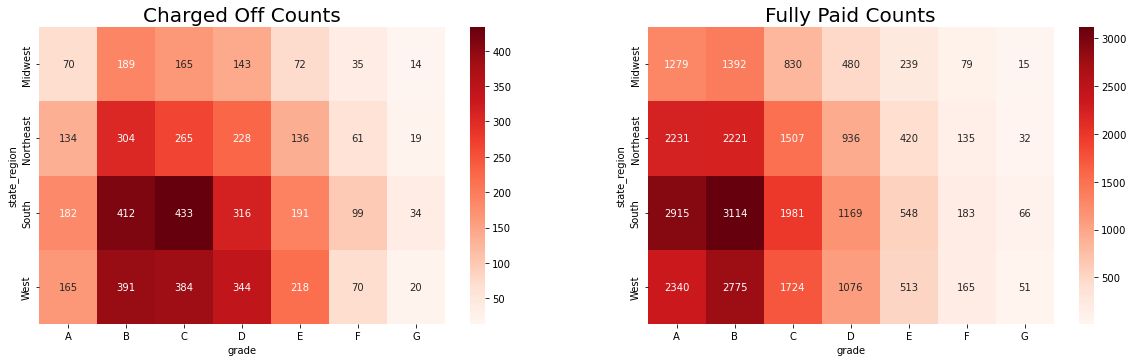

In [110]:
# Irrespective of people's region, people having grades C and up to F end up being defaulters
region_grade_charged_off_HM = pd.pivot_table(data=charged_off,index="state_region",columns="grade",values="loan_status",aggfunc='count')
region_grade_fully_paid_HM = pd.pivot_table(data=fully_paid,index="state_region",columns="grade",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(region_grade_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(region_grade_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

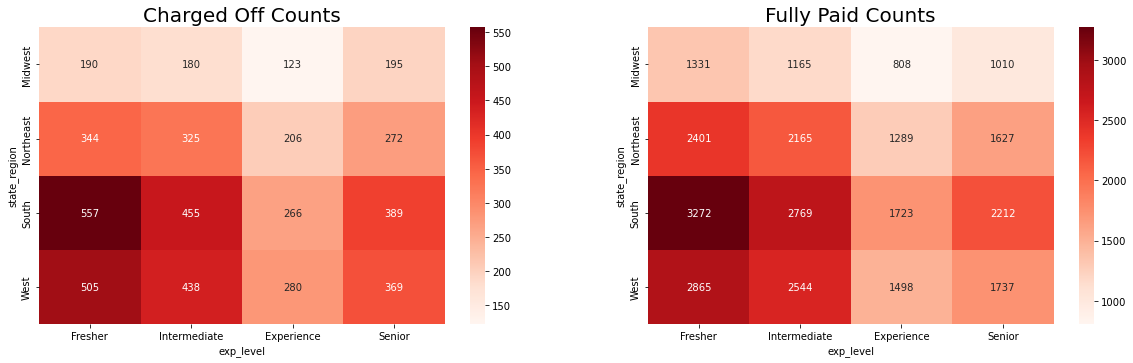

In [111]:
# Experienced and Senior people from West region and Seniors from Midwest region tend to become defaulters
region_exp_charged_off_HM = pd.pivot_table(data=charged_off,index="state_region",columns="exp_level",values="loan_status",aggfunc='count')
region_exp_fully_paid_HM = pd.pivot_table(data=fully_paid,index="state_region",columns="exp_level",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(region_exp_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(region_exp_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

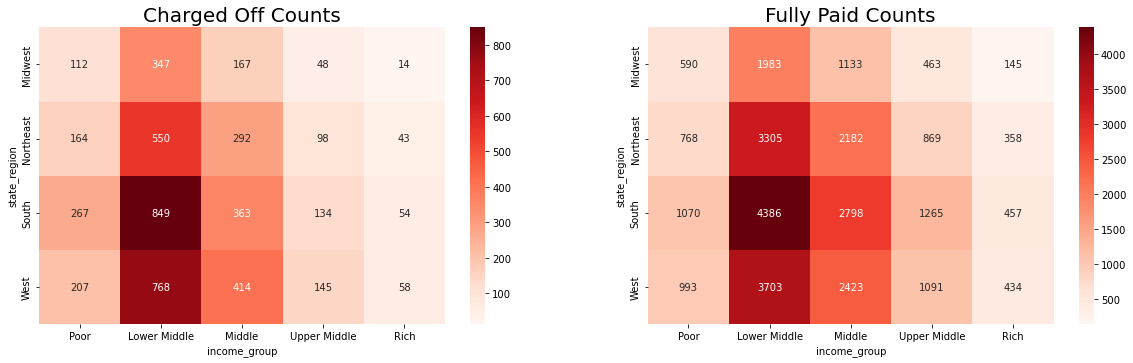

In [112]:
#  Poor people in all the regions end up being defaulters
region_inc_charged_off_HM = pd.pivot_table(data=charged_off,index="state_region",columns="income_group",values="loan_status",aggfunc='count')
region_inc_fully_paid_HM = pd.pivot_table(data=fully_paid,index="state_region",columns="income_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(region_inc_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(region_inc_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

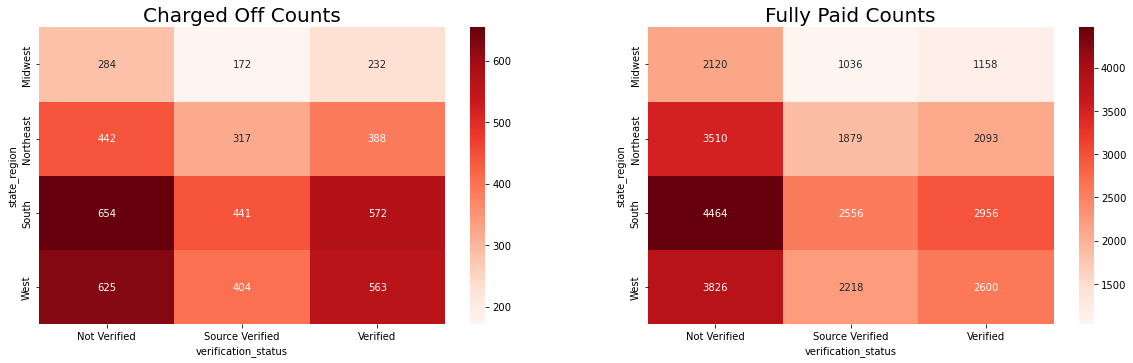

In [113]:
# Verified people from all the regions are advised to be sourc-verified as they end up being defaulters
# also Not-verified people from West region tend to become defaulters
region_verify_charged_off_HM = pd.pivot_table(data=charged_off,index="state_region",columns="verification_status",values="loan_status",aggfunc='count')
region_verify_fully_paid_HM = pd.pivot_table(data=fully_paid,index="state_region",columns="verification_status",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(region_verify_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(region_verify_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

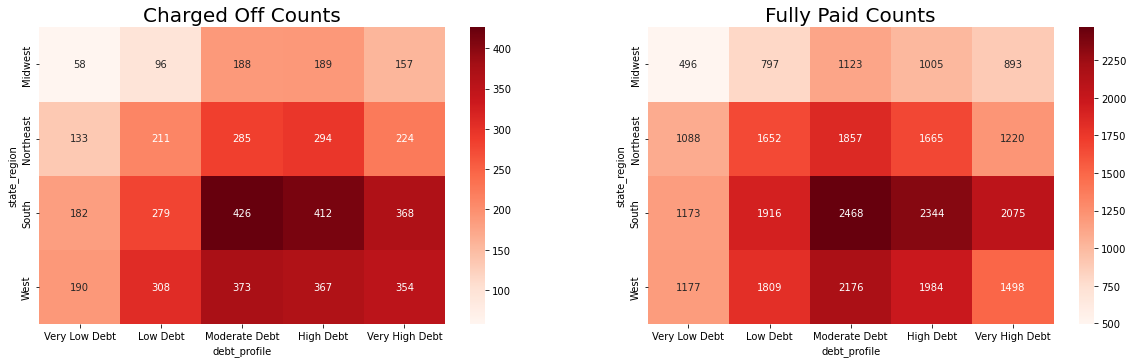

In [114]:
# People from West region who are having high and very high debt end up in being defaulters
region_dti_charged_off_HM = pd.pivot_table(data=charged_off,index="state_region",columns="debt_profile",values="loan_status",aggfunc='count')
region_dti_fully_paid_HM = pd.pivot_table(data=fully_paid,index="state_region",columns="debt_profile",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(region_dti_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(region_dti_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

## Analyzing loan_volume with others

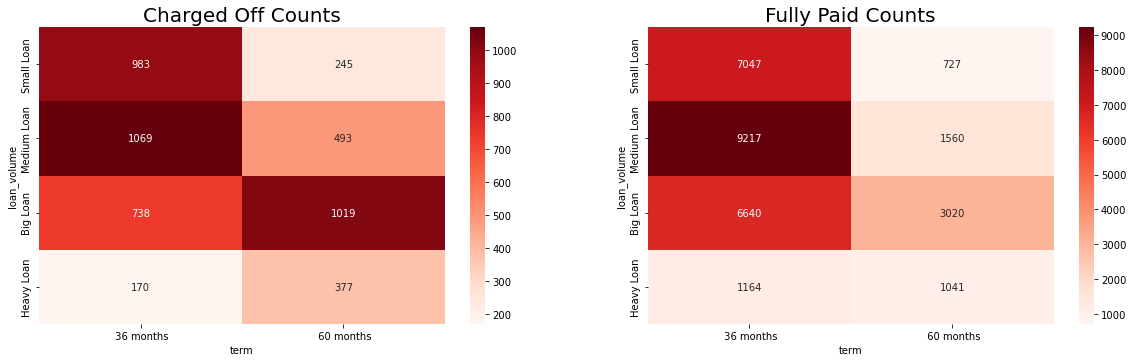

In [115]:
# People who take loan for 5 years more likely end up in being defaulters. 
# And people who take small loans for 3 years also become defaulters
loanvol_term_charged_off_HM = pd.pivot_table(data=charged_off,index="loan_volume",columns="term",values="loan_status",aggfunc='count')
loanvol_term_fully_paid_HM = pd.pivot_table(data=fully_paid,index="loan_volume",columns="term",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(loanvol_term_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(loanvol_term_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

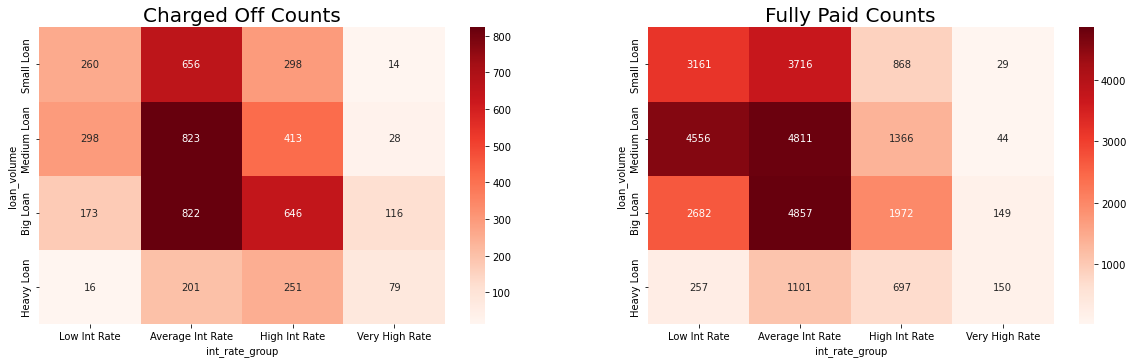

In [116]:
# Irrespective of loan amount, people with more than 15% interest rate end up being defaulters
# Also people who take loan beyond USD10k for int rate of more than 15% end up being defaulters
loanvol_int_charged_off_HM = pd.pivot_table(data=charged_off,index="loan_volume",columns="int_rate_group",values="loan_status",aggfunc='count')
loanvol_int_fully_paid_HM = pd.pivot_table(data=fully_paid,index="loan_volume",columns="int_rate_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(loanvol_int_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(loanvol_int_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

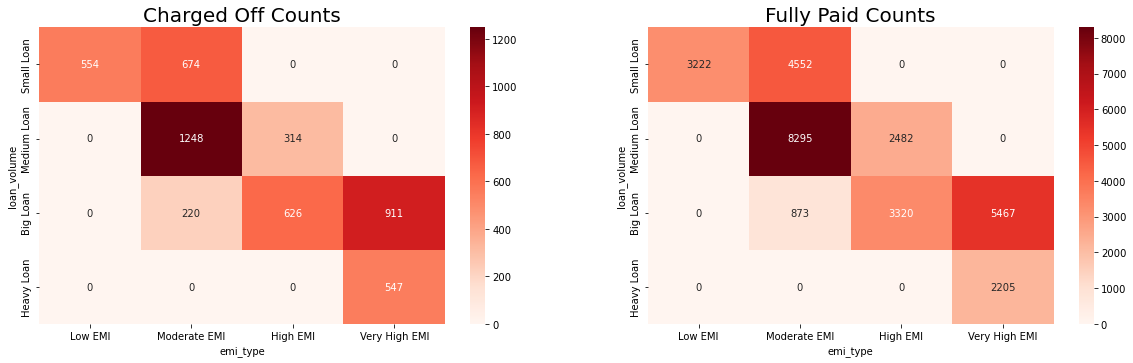

In [117]:
# Irrespective of loan amount, people with more than USD300 EMI end up being defaulters
loanvol_emi_charged_off_HM = pd.pivot_table(data=charged_off,index="loan_volume",columns="emi_type",values="loan_status",aggfunc='count')
loanvol_emi_fully_paid_HM = pd.pivot_table(data=fully_paid,index="loan_volume",columns="emi_type",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(loanvol_emi_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(loanvol_emi_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

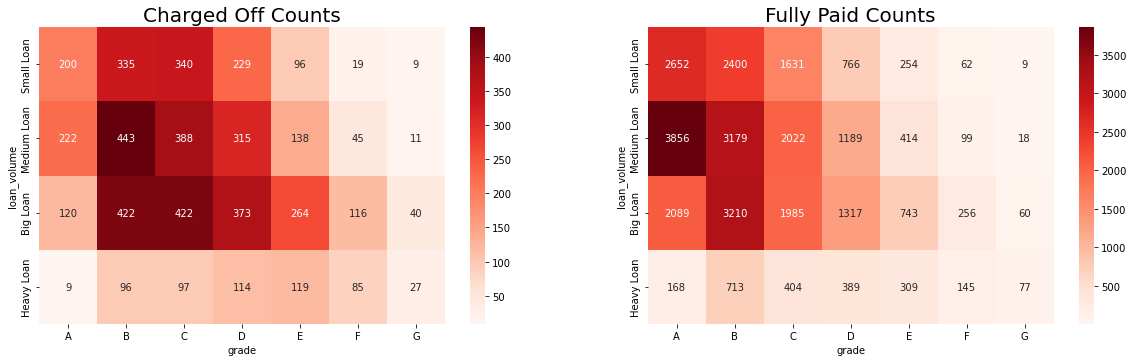

In [118]:
# People who take more than USD10k loan and have grade between B and E are more likely to be defaulters
loanvol_grade_charged_off_HM = pd.pivot_table(data=charged_off,index="loan_volume",columns="grade",values="loan_status",aggfunc='count')
loanvol_grade_fully_paid_HM = pd.pivot_table(data=fully_paid,index="loan_volume",columns="grade",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(loanvol_grade_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(loanvol_grade_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

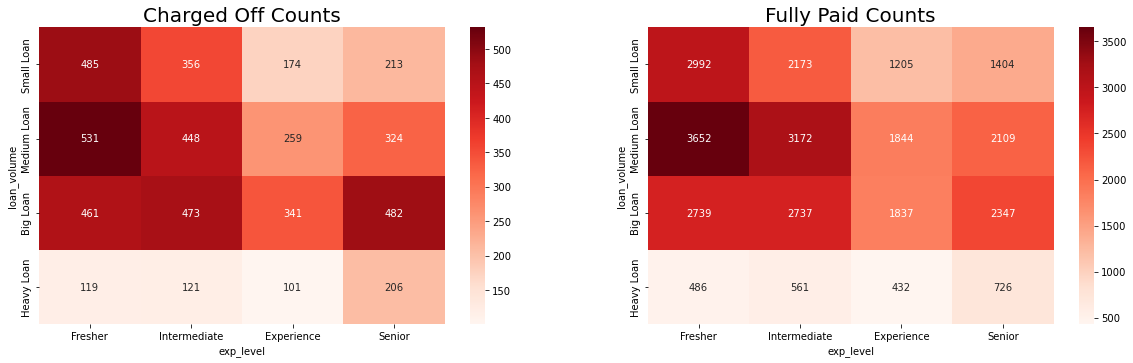

In [119]:
# People with more than 5 years of exp who take loan between USD5k and USD20k end up being defaulters
loanvol_exp_charged_off_HM = pd.pivot_table(data=charged_off,index="loan_volume",columns="exp_level",values="loan_status",aggfunc='count')
loanvol_exp_fully_paid_HM = pd.pivot_table(data=fully_paid,index="loan_volume",columns="exp_level",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(loanvol_exp_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(loanvol_exp_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

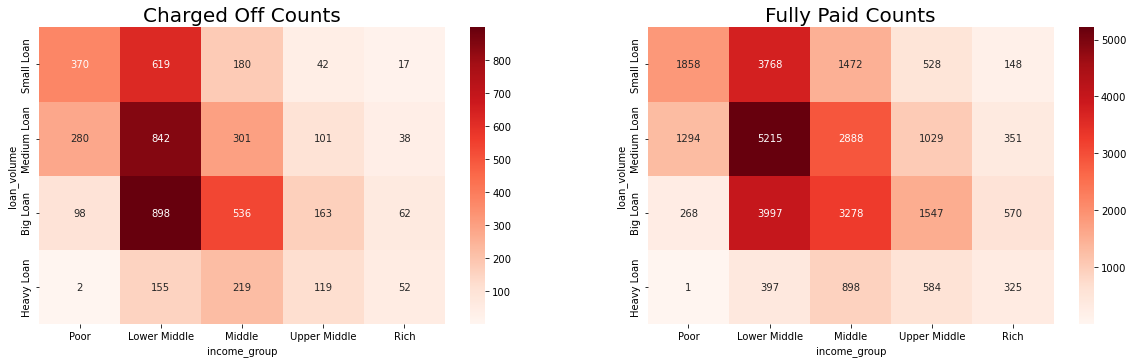

In [120]:
# It is riskier to give loan of amount between USD20k and USD30k to people with annual income between USD30k and USD60k
loanvol_inc_charged_off_HM = pd.pivot_table(data=charged_off,index="loan_volume",columns="income_group",values="loan_status",aggfunc='count')
loanvol_inc_fully_paid_HM = pd.pivot_table(data=fully_paid,index="loan_volume",columns="income_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(loanvol_inc_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(loanvol_inc_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

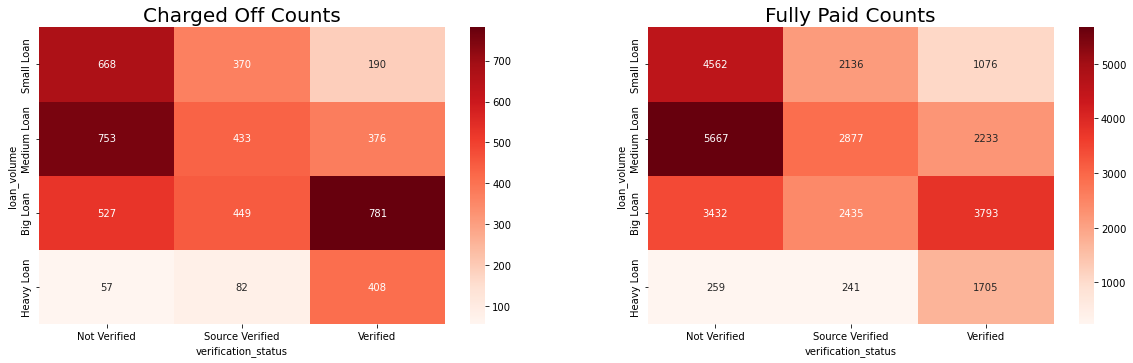

In [121]:
# It is recommended to verify income source of everyone irrespective of their annual income
loanvol_verify_charged_off_HM = pd.pivot_table(data=charged_off,index="loan_volume",columns="verification_status",values="loan_status",aggfunc='count')
loanvol_verify_fully_paid_HM = pd.pivot_table(data=fully_paid,index="loan_volume",columns="verification_status",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(loanvol_verify_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(loanvol_verify_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

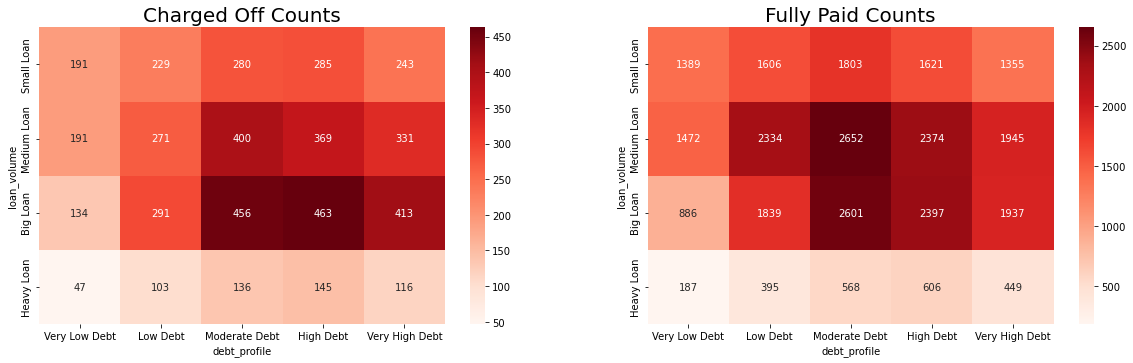

In [122]:
# People who have dti between 15% and 20% and take loan between USD10k and USD20k end up being defaulter
loanvol_dti_charged_off_HM = pd.pivot_table(data=charged_off,index="loan_volume",columns="debt_profile",values="loan_status",aggfunc='count')
loanvol_dti_fully_paid_HM = pd.pivot_table(data=fully_paid,index="loan_volume",columns="debt_profile",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(loanvol_dti_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(loanvol_dti_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

## Analyzing term with others

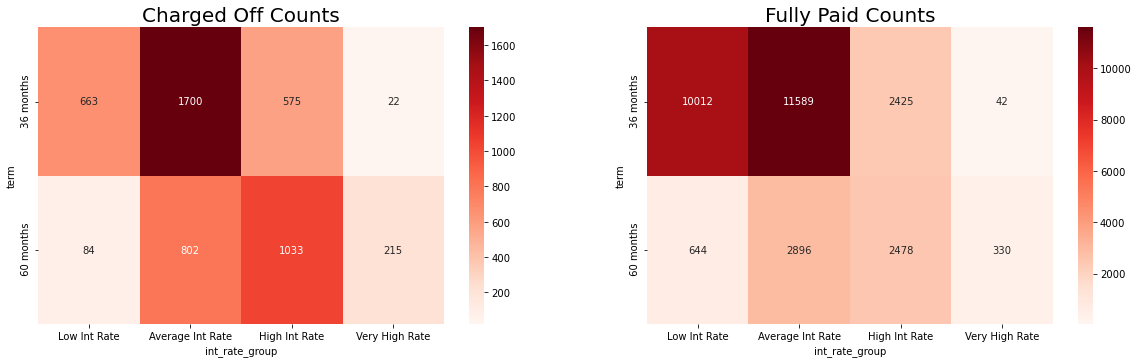

In [123]:
# loans with above 10% int rate and 5 years loan tenure end up in being defaulters
# loans with above 15% int rate and 3 years laon tenure end up in being defaulters
term_int_charged_off_HM = pd.pivot_table(data=charged_off,index="term",columns="int_rate_group",values="loan_status",aggfunc='count')
term_int_fully_paid_HM = pd.pivot_table(data=fully_paid,index="term",columns="int_rate_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(term_int_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(term_int_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

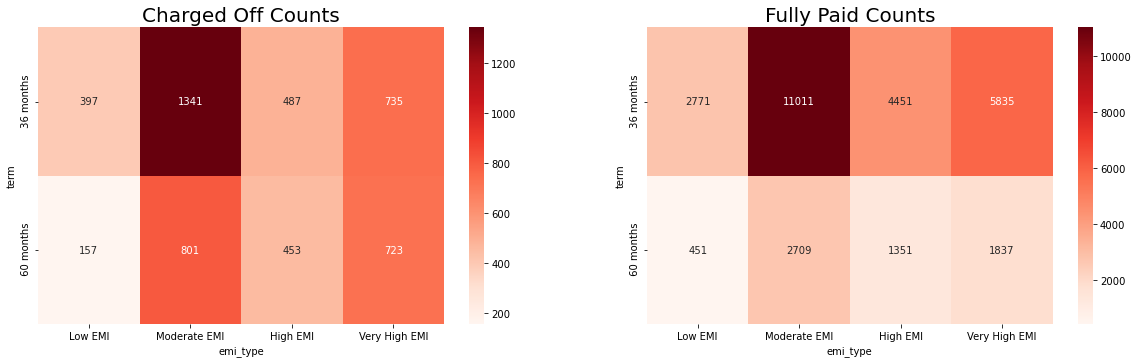

In [124]:
# EMI of more than USD100 and 5 years loan tenure end up in defaulters
# EMI of more than USD300 and 3 years loan tenure end up in defaulters
term_emi_charged_off_HM = pd.pivot_table(data=charged_off,index="term",columns="emi_type",values="loan_status",aggfunc='count')
term_emi_fully_paid_HM = pd.pivot_table(data=fully_paid,index="term",columns="emi_type",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(term_emi_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(term_emi_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

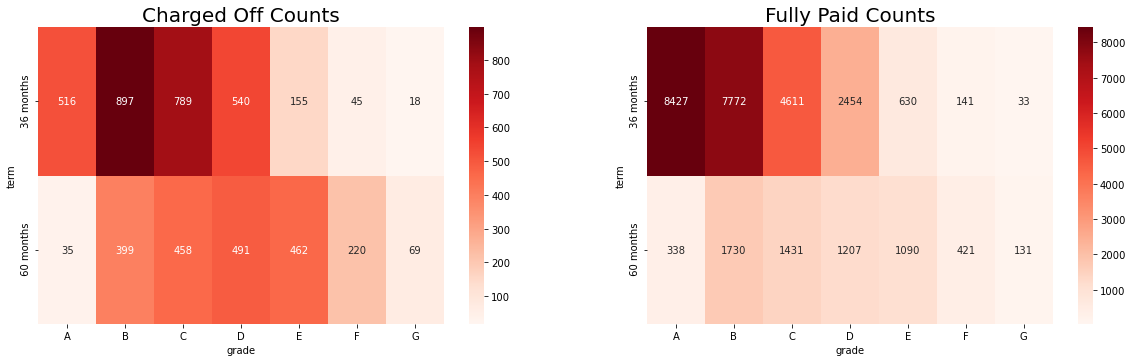

In [125]:
# People who belong to grades B and above, irrespective of their loan tenure end up in being defaulters
term_grade_charged_off_HM = pd.pivot_table(data=charged_off,index="term",columns="grade",values="loan_status",aggfunc='count')
term_grade_fully_paid_HM = pd.pivot_table(data=fully_paid,index="term",columns="grade",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(term_grade_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(term_grade_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

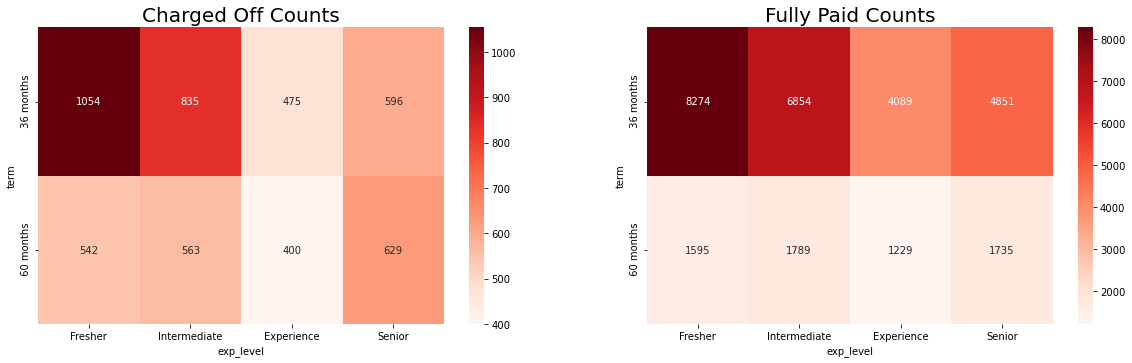

In [126]:
# People who take loan for 5 years, irrespective of their experience end up in being defaulters
term_exp_charged_off_HM = pd.pivot_table(data=charged_off,index="term",columns="exp_level",values="loan_status",aggfunc='count')
term_exp_fully_paid_HM = pd.pivot_table(data=fully_paid,index="term",columns="exp_level",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(term_exp_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(term_exp_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

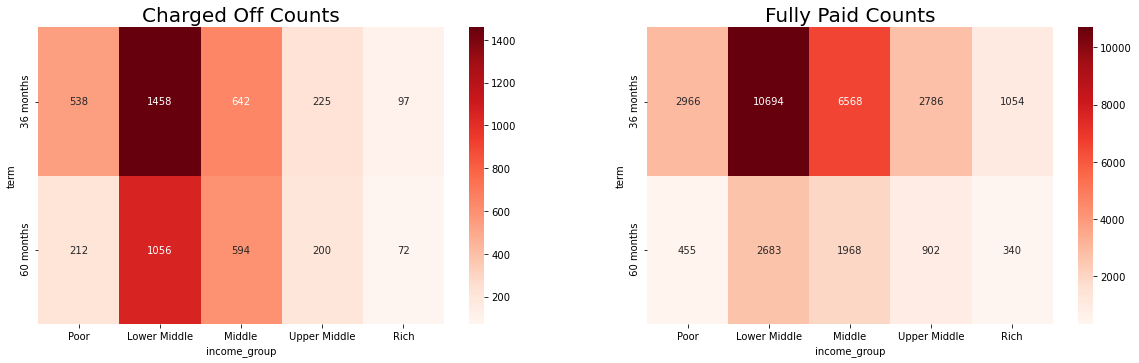

In [127]:
# People who take loan for 5 years, irrespective of their income end up in being defaulters
term_inc_charged_off_HM = pd.pivot_table(data=charged_off,index="term",columns="income_group",values="loan_status",aggfunc='count')
term_inc_fully_paid_HM = pd.pivot_table(data=fully_paid,index="term",columns="income_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(term_inc_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(term_inc_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

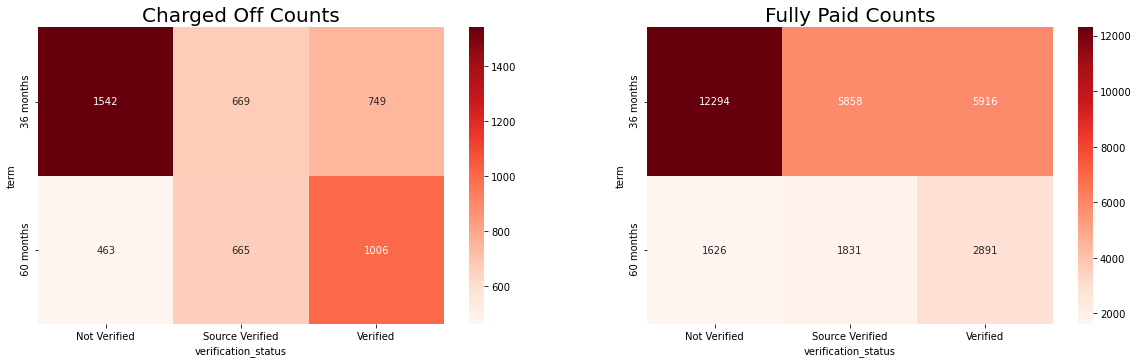

In [128]:
# People who take loan for 5 years, irrespective of their income verification end up in being defaulters
term_verify_charged_off_HM = pd.pivot_table(data=charged_off,index="term",columns="verification_status",values="loan_status",aggfunc='count')
term_verify_fully_paid_HM = pd.pivot_table(data=fully_paid,index="term",columns="verification_status",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(term_verify_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(term_verify_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

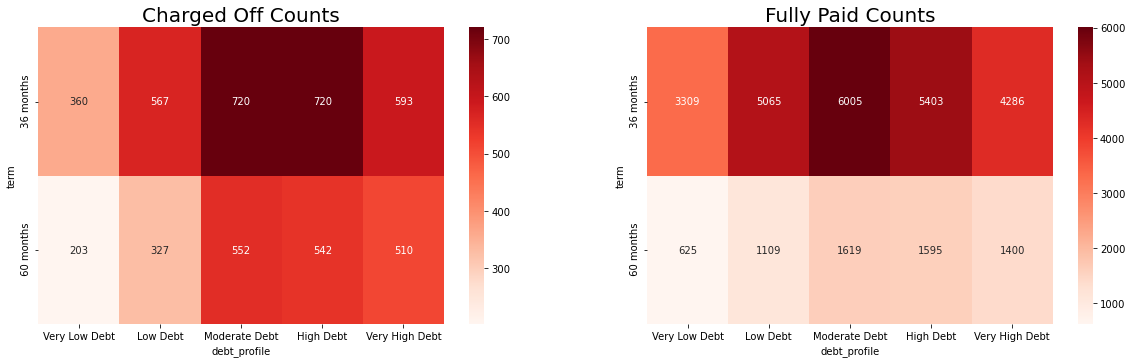

In [129]:
# People who take loan for 5 years, irrespective of their dti end up in being defaulters
# People who take loan for 3 years, and dti between 15% and 20%, end up being defaulters
term_dti_charged_off_HM = pd.pivot_table(data=charged_off,index="term",columns="debt_profile",values="loan_status",aggfunc='count')
term_dti_fully_paid_HM = pd.pivot_table(data=fully_paid,index="term",columns="debt_profile",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(term_dti_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(term_dti_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

## Analyzing int_rate with others

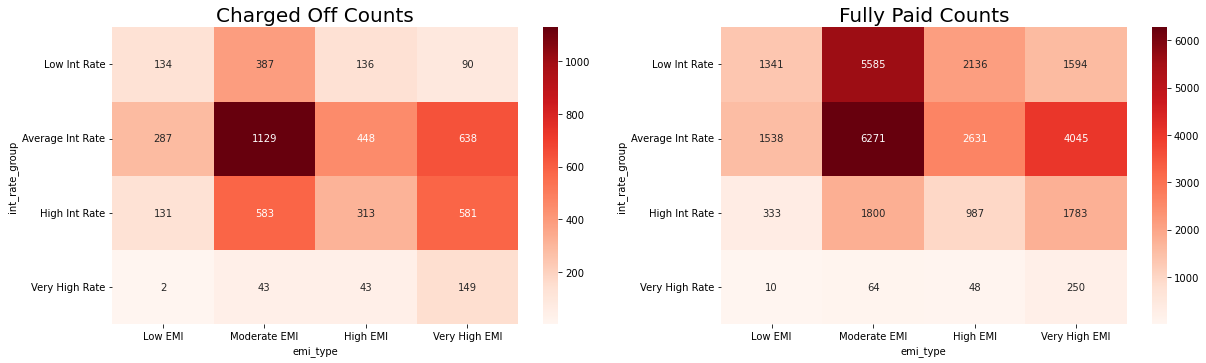

In [130]:
# People who take loans on int rate more than 15% and pay EMI of more than USD300 end up being defaulters
int_emi_charged_off_HM = pd.pivot_table(data=charged_off,index="int_rate_group",columns="emi_type",values="loan_status",aggfunc='count')
int_emi_fully_paid_HM = pd.pivot_table(data=fully_paid,index="int_rate_group",columns="emi_type",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(int_emi_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(int_emi_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

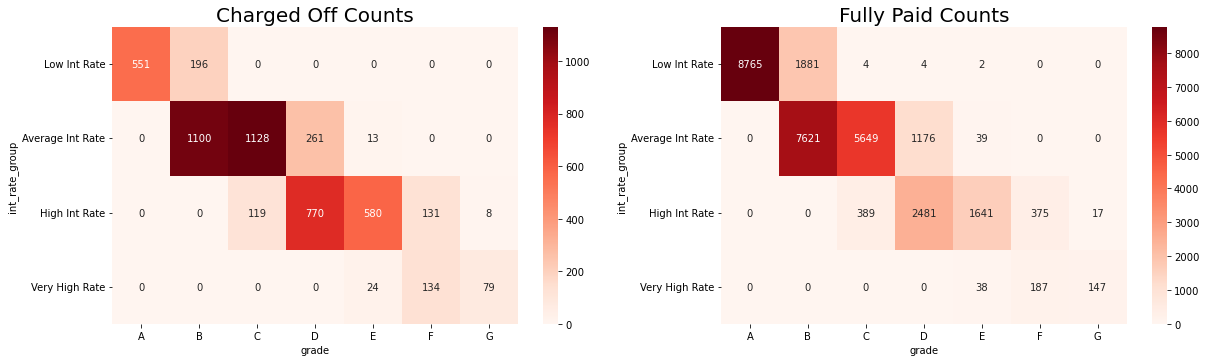

In [131]:
# People who pay int rate more than 10% and belong to grade B and higher end up in defaulters
int_grade_charged_off_HM = pd.pivot_table(data=charged_off,index="int_rate_group",columns="grade",values="loan_status",aggfunc='count')
int_grade_fully_paid_HM = pd.pivot_table(data=fully_paid,index="int_rate_group",columns="grade",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(int_grade_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(int_grade_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

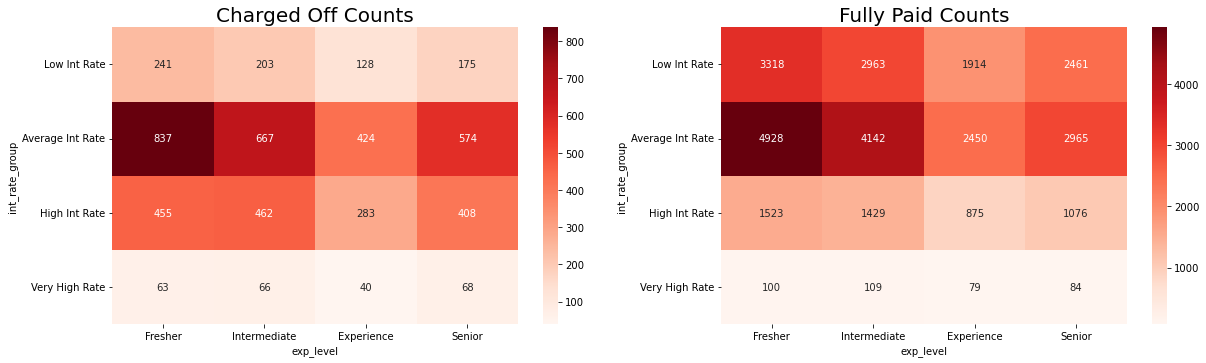

In [132]:
# People with int rate between 15% and 20% end up being defaulters
int_exp_charged_off_HM = pd.pivot_table(data=charged_off,index="int_rate_group",columns="exp_level",values="loan_status",aggfunc='count')
int_exp_fully_paid_HM = pd.pivot_table(data=fully_paid,index="int_rate_group",columns="exp_level",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(int_exp_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(int_exp_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

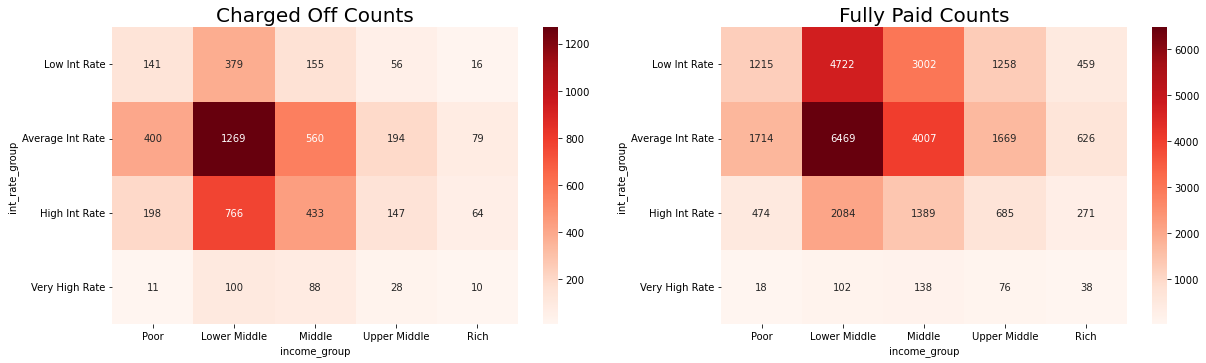

In [133]:
# People who earn between USD30K and USD60K with int rate between 15% and 20% end up being defaulters
int_inc_charged_off_HM = pd.pivot_table(data=charged_off,index="int_rate_group",columns="income_group",values="loan_status",aggfunc='count')
int_inc_fully_paid_HM = pd.pivot_table(data=fully_paid,index="int_rate_group",columns="income_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(int_inc_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(int_inc_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

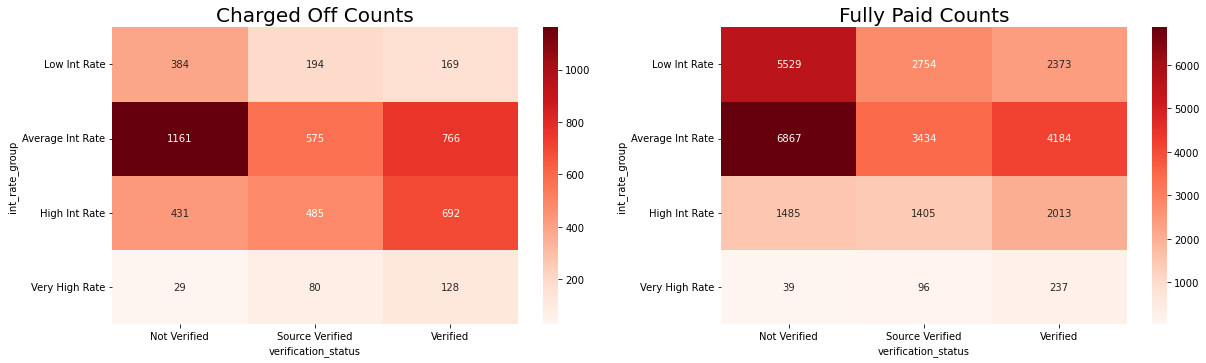

In [134]:
# People who take loan with high int rate, irrespective of their verification status, end up in being defaulters
int_verify_charged_off_HM = pd.pivot_table(data=charged_off,index="int_rate_group",columns="verification_status",values="loan_status",aggfunc='count')
int_verify_fully_paid_HM = pd.pivot_table(data=fully_paid,index="int_rate_group",columns="verification_status",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(int_verify_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(int_verify_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

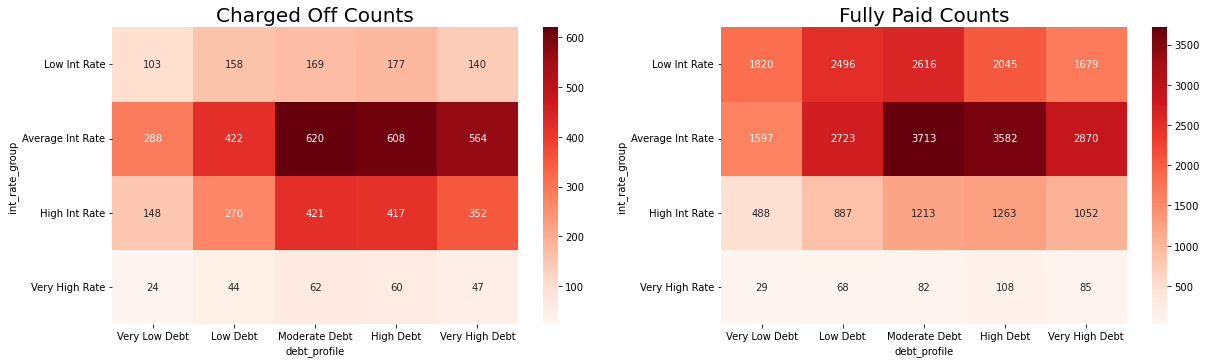

In [135]:
# People who take loan with high int rate, irrespective of their dti, end up in being defaulters
int_dti_charged_off_HM = pd.pivot_table(data=charged_off,index="int_rate_group",columns="debt_profile",values="loan_status",aggfunc='count')
int_dti_fully_paid_HM = pd.pivot_table(data=fully_paid,index="int_rate_group",columns="debt_profile",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(int_dti_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(int_dti_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

## Analyzing installment with others

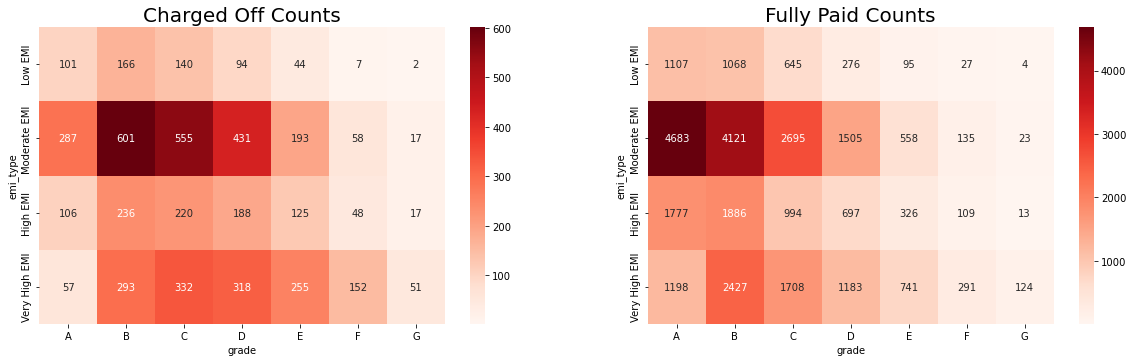

In [136]:
# People who pay EMI of more than USD300 and who belong to grades more than B end up in being defaulters
emi_grade_charged_off_HM = pd.pivot_table(data=charged_off,index="emi_type",columns="grade",values="loan_status",aggfunc='count')
emi_grade_fully_paid_HM = pd.pivot_table(data=fully_paid,index="emi_type",columns="grade",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(emi_grade_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(emi_grade_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

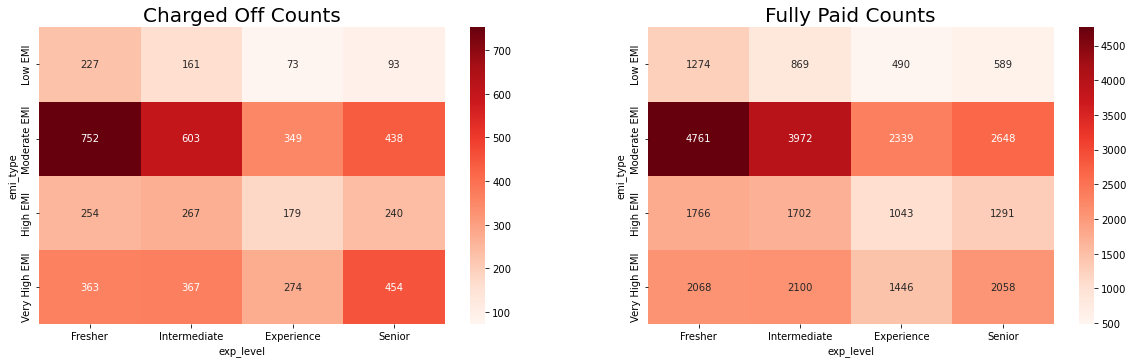

In [137]:
# People who pay EMI more than USD300 irrespective of their experience end up in being defaulters
emi_exp_charged_off_HM = pd.pivot_table(data=charged_off,index="emi_type",columns="exp_level",values="loan_status",aggfunc='count')
emi_exp_fully_paid_HM = pd.pivot_table(data=fully_paid,index="emi_type",columns="exp_level",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(emi_exp_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(emi_exp_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

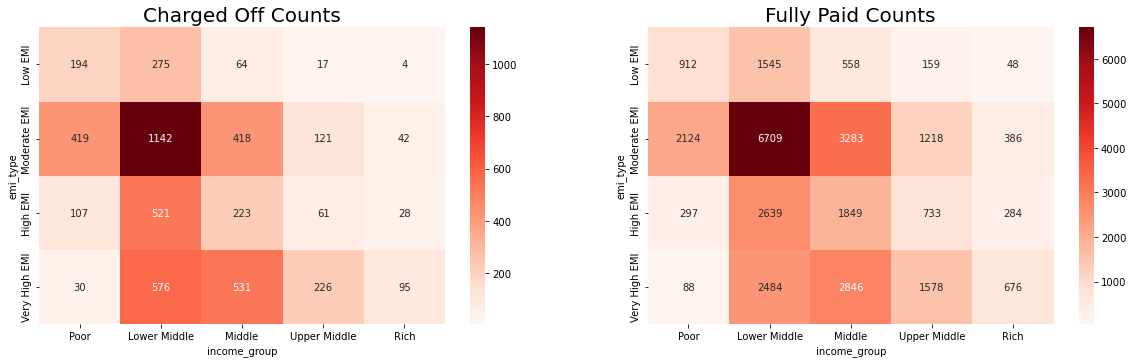

In [138]:
# People who pay EMI more than USD300 irrespective of their annual income end up in being defaulters
emi_inc_charged_off_HM = pd.pivot_table(data=charged_off,index="emi_type",columns="income_group",values="loan_status",aggfunc='count')
emi_inc_fully_paid_HM = pd.pivot_table(data=fully_paid,index="emi_type",columns="income_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(emi_inc_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(emi_inc_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

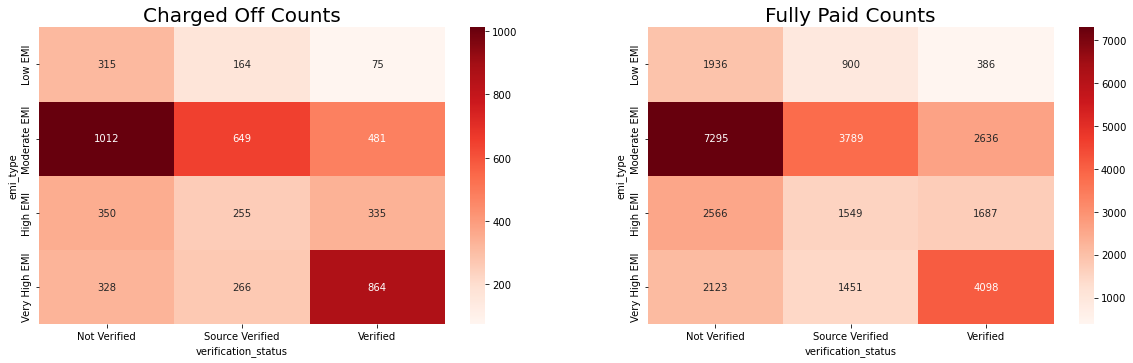

In [139]:
# People who pay EMI more than USD300 irrespective of their income source verification end up in being defaulters
emi_verify_charged_off_HM = pd.pivot_table(data=charged_off,index="emi_type",columns="verification_status",values="loan_status",aggfunc='count')
emi_verify_fully_paid_HM = pd.pivot_table(data=fully_paid,index="emi_type",columns="verification_status",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(emi_verify_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(emi_verify_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

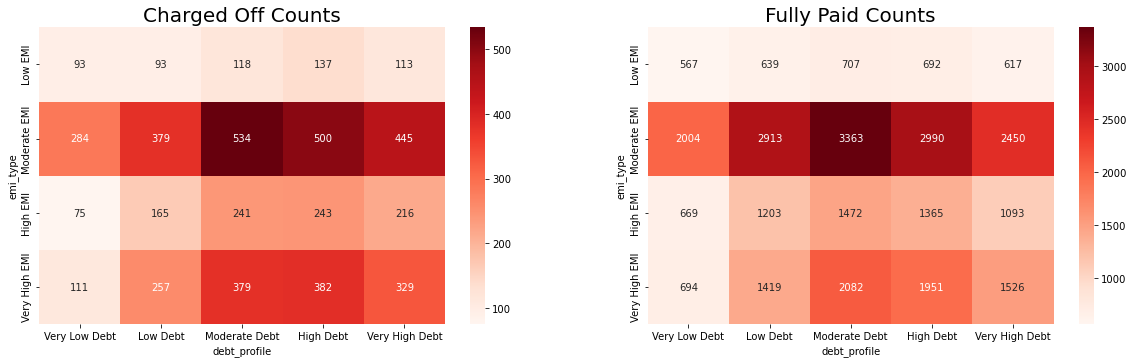

In [140]:
# People who pay EMI more than USD300 irrespective of their dti end up in being defaulters
emi_dti_charged_off_HM = pd.pivot_table(data=charged_off,index="emi_type",columns="debt_profile",values="loan_status",aggfunc='count')
emi_dti_fully_paid_HM = pd.pivot_table(data=fully_paid,index="emi_type",columns="debt_profile",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(emi_dti_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(emi_dti_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

## Analyzing grade with others

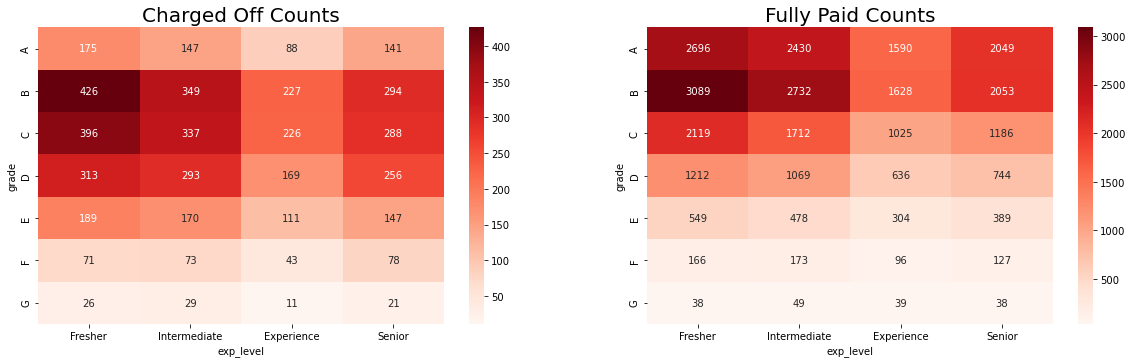

In [141]:
# People with grade C and above, irrespective of their exp level, have a tendency to become defaulter
grade_exp_charged_off_HM = pd.pivot_table(data=charged_off,index="grade",columns="exp_level",values="loan_status",aggfunc='count')
grade_exp_fully_paid_HM = pd.pivot_table(data=fully_paid,index="grade",columns="exp_level",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(grade_exp_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(grade_exp_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

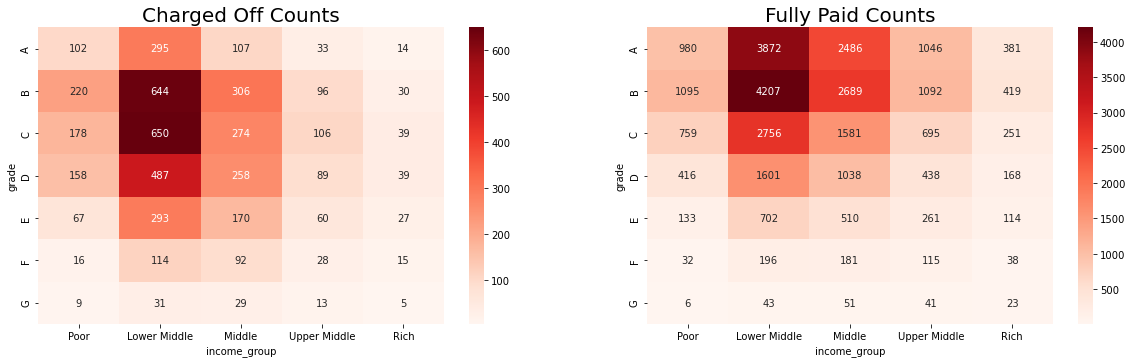

In [142]:
# People with grade C and above, irrespective of their annual income, have a tendency to become defaulter
grade_inc_charged_off_HM = pd.pivot_table(data=charged_off,index="grade",columns="income_group",values="loan_status",aggfunc='count')
grade_inc_fully_paid_HM = pd.pivot_table(data=fully_paid,index="grade",columns="income_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(grade_inc_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(grade_inc_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

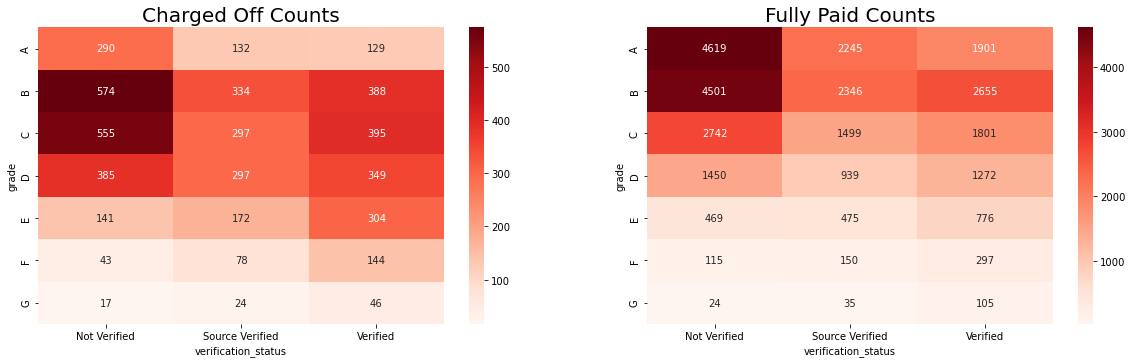

In [143]:
# People with grade C and above, irrespective of their income source verification, have a tendency to become defaulter
grade_verify_charged_off_HM = pd.pivot_table(data=charged_off,index="grade",columns="verification_status",values="loan_status",aggfunc='count')
grade_verify_fully_paid_HM = pd.pivot_table(data=fully_paid,index="grade",columns="verification_status",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(grade_verify_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(grade_verify_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

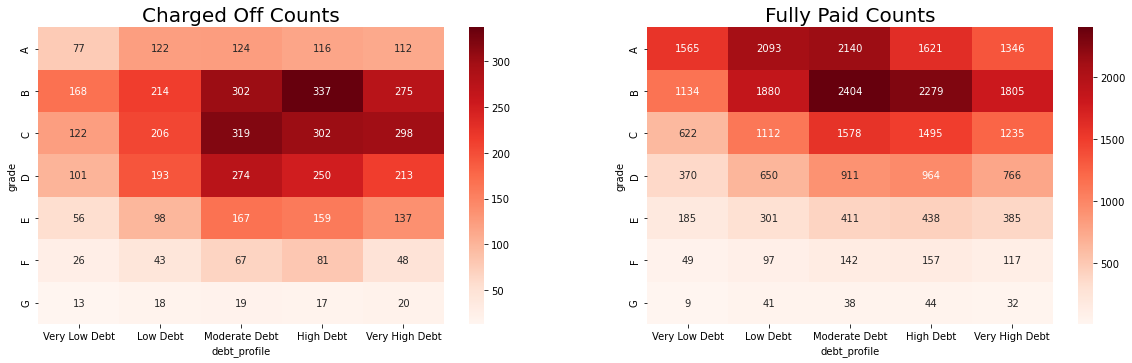

In [144]:
# People with grade C and above, irrespective of their dti, have a tendency to become defaulter
grade_dti_charged_off_HM = pd.pivot_table(data=charged_off,index="grade",columns="debt_profile",values="loan_status",aggfunc='count')
grade_dti_fully_paid_HM = pd.pivot_table(data=fully_paid,index="grade",columns="debt_profile",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(grade_dti_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(grade_dti_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

## Analyzing emp_length with others

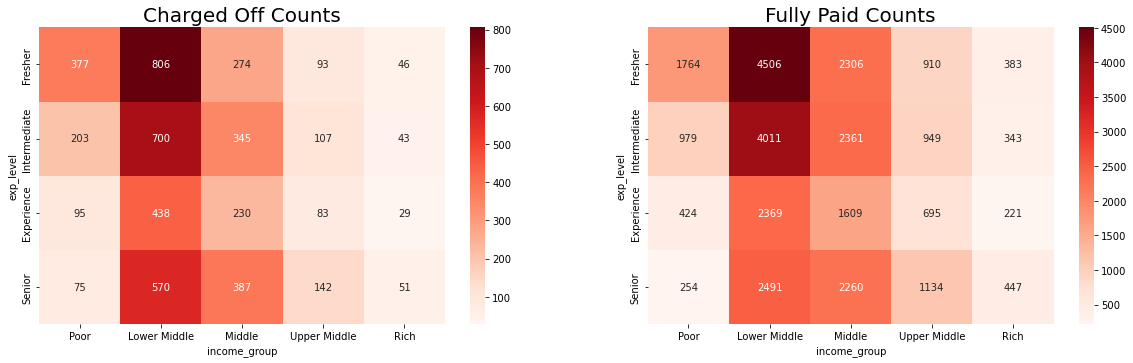

In [145]:
# People who are more than 10 years of experienced, and are earning between USD30k and USD60k become defaulters
exp_inc_charged_off_HM = pd.pivot_table(data=charged_off,index="exp_level",columns="income_group",values="loan_status",aggfunc='count')
exp_inc_fully_paid_HM = pd.pivot_table(data=fully_paid,index="exp_level",columns="income_group",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(exp_inc_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(exp_inc_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

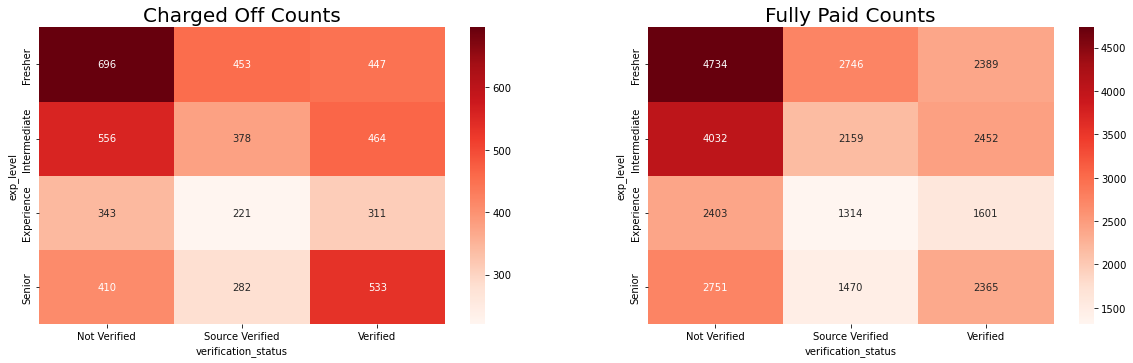

In [146]:
# People whose income source is not verified become loan defaulters irrespective of their experience. That is their
# verified income might not be genuine
exp_verify_charged_off_HM = pd.pivot_table(data=charged_off,index="exp_level",columns="verification_status",values="loan_status",aggfunc='count')
exp_verify_fully_paid_HM = pd.pivot_table(data=fully_paid,index="exp_level",columns="verification_status",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(exp_verify_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(exp_verify_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

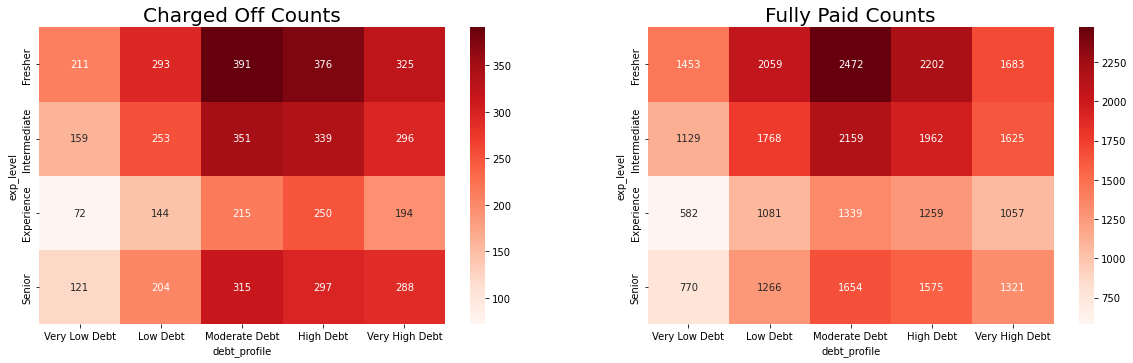

In [147]:
# People who have dti of more than 10% end up being defaulters irrespective of their experience
exp_dti_charged_off_HM = pd.pivot_table(data=charged_off,index="exp_level",columns="debt_profile",values="loan_status",aggfunc='count')
exp_dti_fully_paid_HM = pd.pivot_table(data=fully_paid,index="exp_level",columns="debt_profile",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(exp_dti_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(exp_dti_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

## Analyzing income_group with others

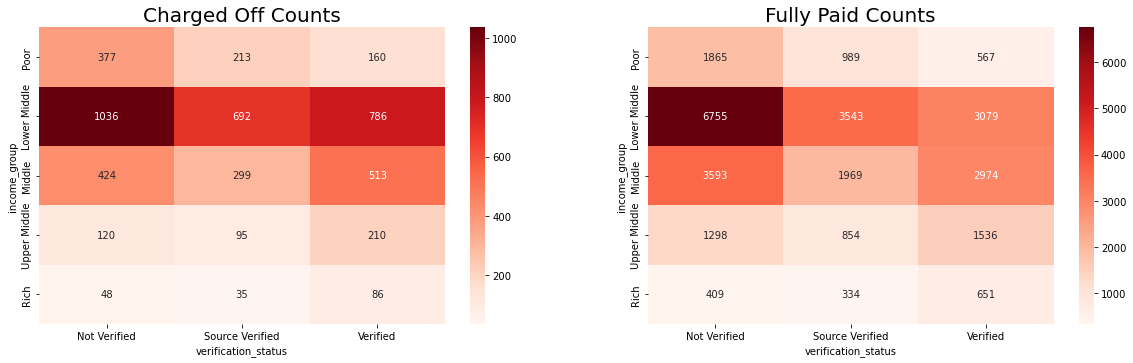

In [148]:
# Poor people whose is income is not verified tend to become defaulters
inc_verify_charged_off_HM = pd.pivot_table(data=charged_off,index="income_group",columns="verification_status",values="loan_status",aggfunc='count')
inc_verify_fully_paid_HM = pd.pivot_table(data=fully_paid,index="income_group",columns="verification_status",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(inc_verify_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(inc_verify_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

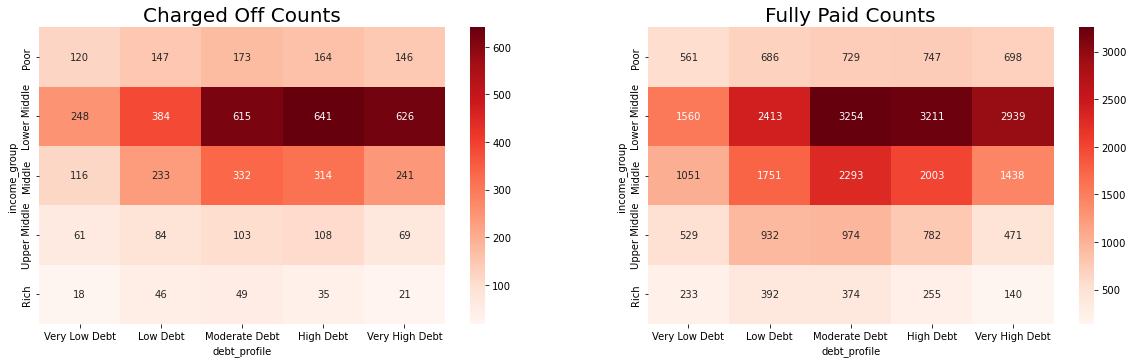

In [149]:
inc_dti_charged_off_HM = pd.pivot_table(data=charged_off,index="income_group",columns="debt_profile",values="loan_status",aggfunc='count')
inc_dti_fully_paid_HM = pd.pivot_table(data=fully_paid,index="income_group",columns="debt_profile",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(inc_dti_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(inc_dti_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()

## Analyzing verification_status with others

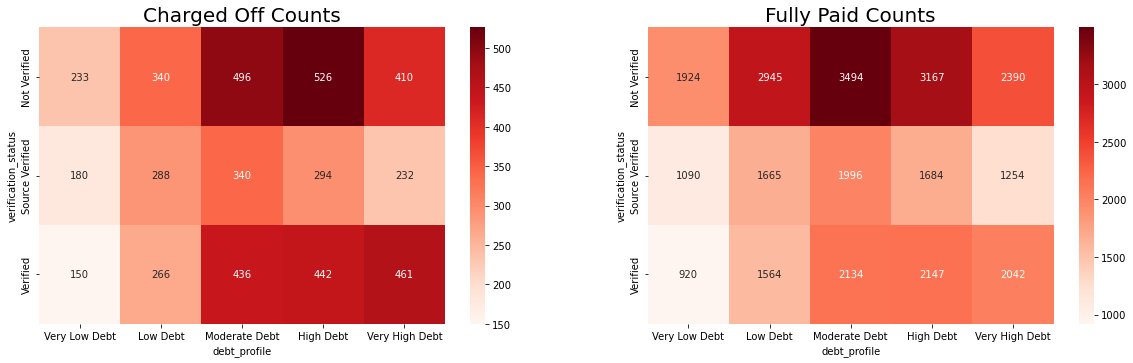

In [150]:
# People with dti more than 10% end up being defaulters irrespective of their income source verification
verify_dti_charged_off_HM = pd.pivot_table(data=charged_off,index="verification_status",columns="debt_profile",values="loan_status",aggfunc='count')
verify_dti_fully_paid_HM = pd.pivot_table(data=fully_paid,index="verification_status",columns="debt_profile",values="loan_status",aggfunc='count')

plt.figure(figsize = (20,12))
plt.subplot(221)
h1 = sns.heatmap(verify_dti_charged_off_HM, cmap = "Reds", annot=True, fmt='g')
h1.set_title("Charged Off Counts", fontsize=20)
plt.subplot(222)
h2 = sns.heatmap(verify_dti_fully_paid_HM, cmap = "Reds", annot=True, fmt='g')
h2.set_title("Fully Paid Counts", fontsize=20)
plt.show()